# Part 2 - Question 1

## Background
The data corresponds to an experiment where RNA was sequenced from many single cells in a population.  Rows correspond to genes.  Columns correspond to cells.  Values correspond to the counts of a given gene in a given cell.

## Install packages

In [1]:
#!pip3 install scanpy
#!pip3 install -U matplotlib
#!pip3 install -U plotly
#!pip3 install leidenalg
#!pip3 install fa2
#!pip install gap-stat
#!pip install xarray-simlab
#!pip install matplotlib-venn
#!pip install statsmodels

In [2]:
import os
import pandas as pd
import math
import scanpy as sc
import numpy as np
from numpy import array
#from collections import deque
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import matplotlib.cm as cm
from sklearn.preprocessing import scale 
#from numpy.linalg import inv
from gap_statistic import OptimalK
from scipy.optimize import curve_fit
from matplotlib_venn import venn3
import matplotlib.cm as cm
#import xarray as xr
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, silhouette_samples, silhouette_score
from sklearn import decomposition, svm
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.naive_bayes import BernoulliNB
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.formula.api as sm
from scipy.stats import chisquare
from statsmodels.sandbox.stats.multicomp import multipletests
import seaborn as sns
%matplotlib inline  

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==1.0.2 statsmodels==0.12.2 python-igraph==0.9.10 pynndescent==0.5.7


In [4]:
results_file = 'write/landerlab.h5ad'  # the file that will store the analysis results

In [5]:
!gunzip "LanderLabACBDataSet.txt.gz"

gzip: LanderLabACBDataSet.txt.gz: No such file or directory


The dataset has 14131 genes (rows) and 123 cell samples (columns). It has binary values, where 0 and 1 indicates the absence and presence of gene, respectively, in the given sample.

Here, the dataset is initialized as an `AnnData` object `adata`, which stores a data matrix `adata.X`, annotation of observations `adata.obs` and variables `adata.var` as a pandas dataframe and unstructured annotation `adata.uns` as a dictionary. Of note, the `adata` object must be transformed because its rows correspond to cells and columns to genes by default. 

The counts of cells were normalized (such that the total count equals to the median of total counts of cells before normalization).

In [6]:
adata = sc.read("LanderLabACBDataSet.txt", sep="\t", cache=True).T

... reading from cache file cache/LanderLabACBDataSet.h5ad


In [7]:
df = pd.DataFrame(adata.X).astype(int)
df.columns = (f'Gene{x}' for x in range(1, len(df.columns)+1))
df.index = (f'Cell{x}' for x in range(1, len(df.index)+1))
df

Gene1  Gene2  Gene3  Gene4  Gene5  Gene6  Gene7  Gene8  Gene9  \
Cell1        0      0      0      0      1      0      0      0      0   
Cell2        0      0      0      0      0      0      0      0      1   
Cell3        0      0      0      0      0      0      0      0      0   
Cell4        0      0      0      0      0      0      0      0      0   
Cell5        0      0      0      0      0      0      0      0      0   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...   
Cell119      1      0      1      0      0      0      0      0      0   
Cell120      0      0      0      0      0      0      0      0      0   
Cell121      0      0      0      0      0      0      0      0      0   
Cell122      0      0      0      0      0      0      0      0      2   
Cell123      1      0      0      0      0      0      0      0      1   

         Gene10  ...  Gene14122  Gene14123  Gene14124  Gene14125  Gene14126  \
Cell1         1  ...          1          1          0          0          1   
Cell2         0  ...          1          0          0          0          0   
Cell3         0  ...          1          0          0          0          0   
Cell4         0  ...          0          1          0          0          0   
Cell5         0  ...          1          0          0          0          0   
...         ...  ...        ...        ...        ...        ...        ...   
Cell119       0  ...          0          2          0          0          0   
Cell120       0  ...          1          0          0          0          0   
Cell121       0  ...          0          0          0          0          0   
Cell122       0  ...          0          0          0          0          0   
Cell123       1  ...          4          2          0          0          0   

         Gene14127  Gene14128  Gene14129  Gene14130  Gene14131  
Cell1            0          0          3          1          0  
Cell2            1          0          0          0          0  
Cell3            0          0          0          0          0  
Cell4            0          1          0          0          0  
Cell5            0          0          0          0          0  
...            ...        ...        ...        ...        ...  
Cell119          0          1          1          0          0  
Cell120          0          0          0          0          0  
Cell121          0          0          0          0          0  
Cell122          0          0          0          0          1  
Cell123          0          1          2          1          1  

[123 rows x 14131 columns]

In [8]:
adata.uns["name"] = "ud" # unstructured dict

In [9]:
adata.obs_names = [f"Cell{i:d}" for i in range(adata.n_obs)]
adata.var_names = [f"Gene{i:d}" for i in range(adata.n_vars)]

In [10]:
# normalize to depth 10 000
sc.pp.normalize_total(adata)

# logaritmize
#sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


## Quality control

Based on visualization of the QC metrics, the `n_genes_by_cell_counts` have a right-skewed distribution (positively-skewed), indicating that the total counts have a lower bound. It is typical of scientific experiments to have a lower bound of zero due to several reasons, including non-negative failure data, measurement processes, time to occurence and size measurements which cannot be less than zero. On the other hand, the `total_counts` is (relatively) normally distributed.

Violin plot summary statistics and the cartesian coordinates of the scatter plot confirm this assessment.

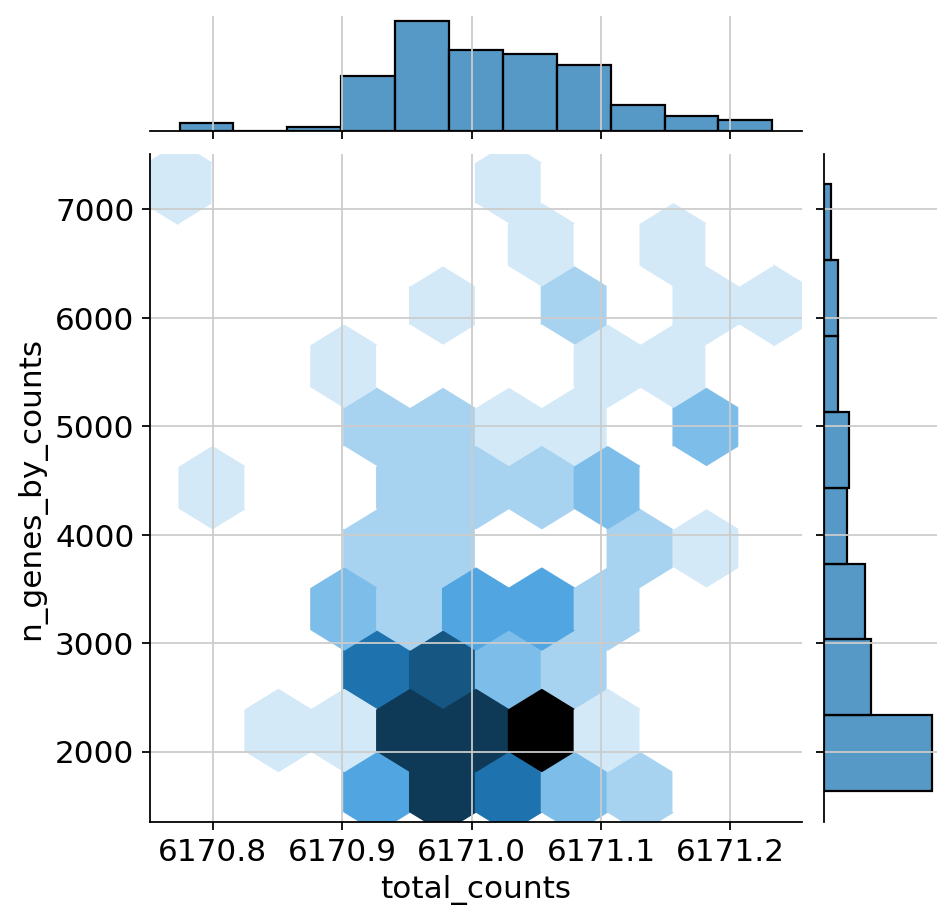

In [11]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sns.jointplot(data=adata.obs, x="total_counts", y="n_genes_by_counts", kind="hex")

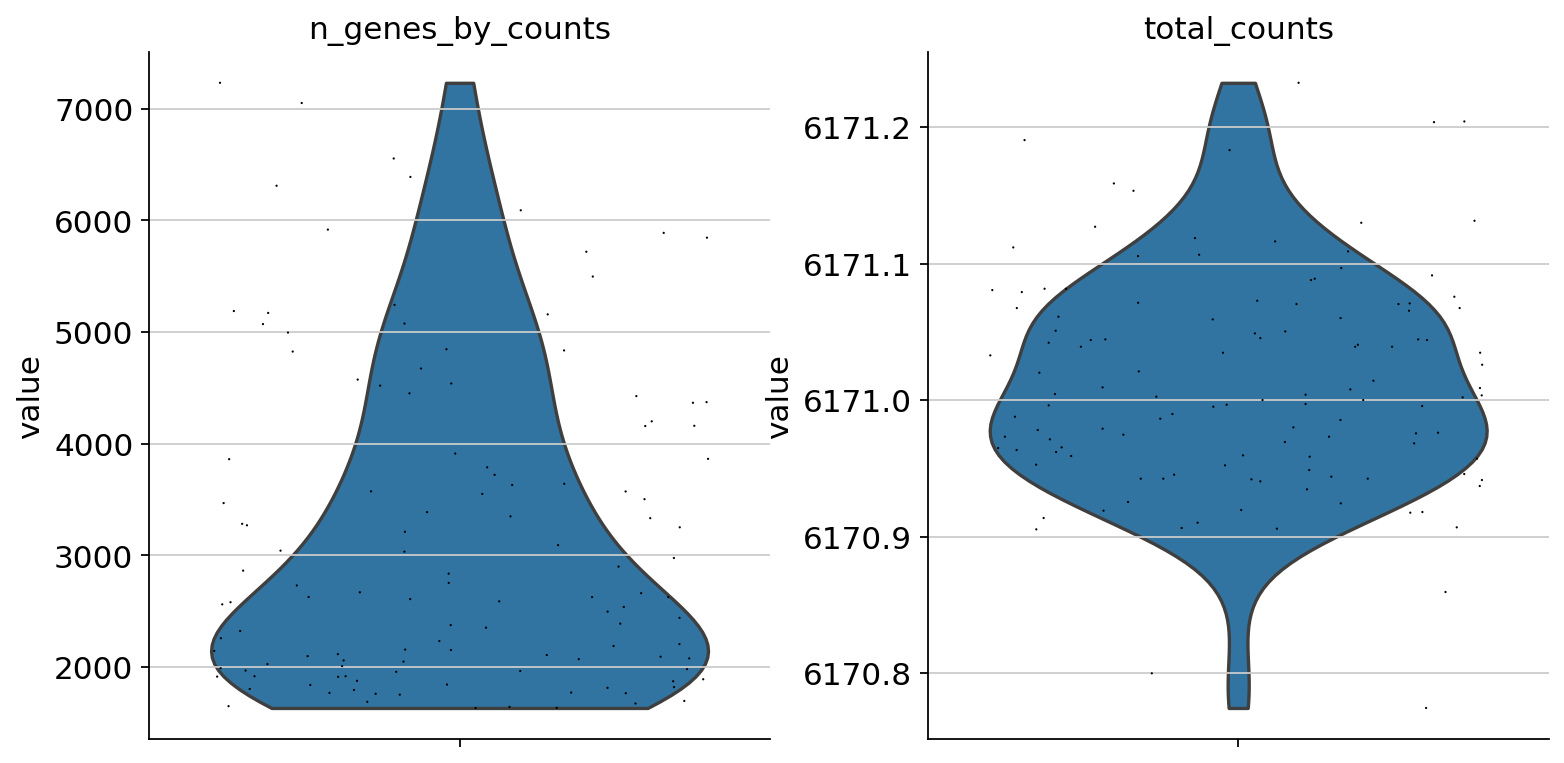

In [12]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts"], jitter=0.4, rotation= 45, multi_panel=True)

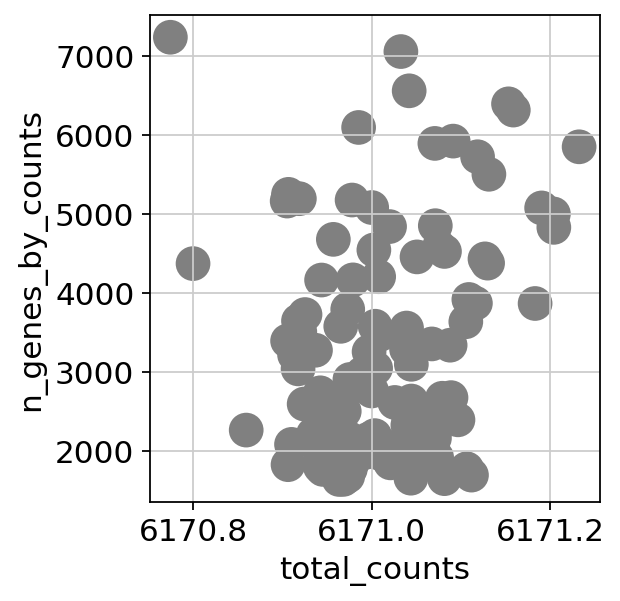

In [13]:
# Scatter plot
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## Filtering

The dataset is filtered to only keep: <br>
- Cells with at least 200 genes expressed 
- Genes that are expressed in at least 3 cells <br>

Outliers were preliminarily defined more than 6,000 genes (6 cells) and total counts between 6170.8 and 6171.2 (4 cells). By removing the outliers, the resultant dataset has a distribution that is slightly less skewed. 

#### Filter by minimum cells and genes

In [14]:
adata.var_names_make_unique()
print("data shape:", adata.shape)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print("data shape:", adata.shape)

data shape: (123, 14131)
filtered out 3001 genes that are detected in less than 3 cells
data shape: (123, 11130)


#### Filter out HYPOTHETICAL mitochondrial gene

normalizing counts per cell
    finished (0:00:00)


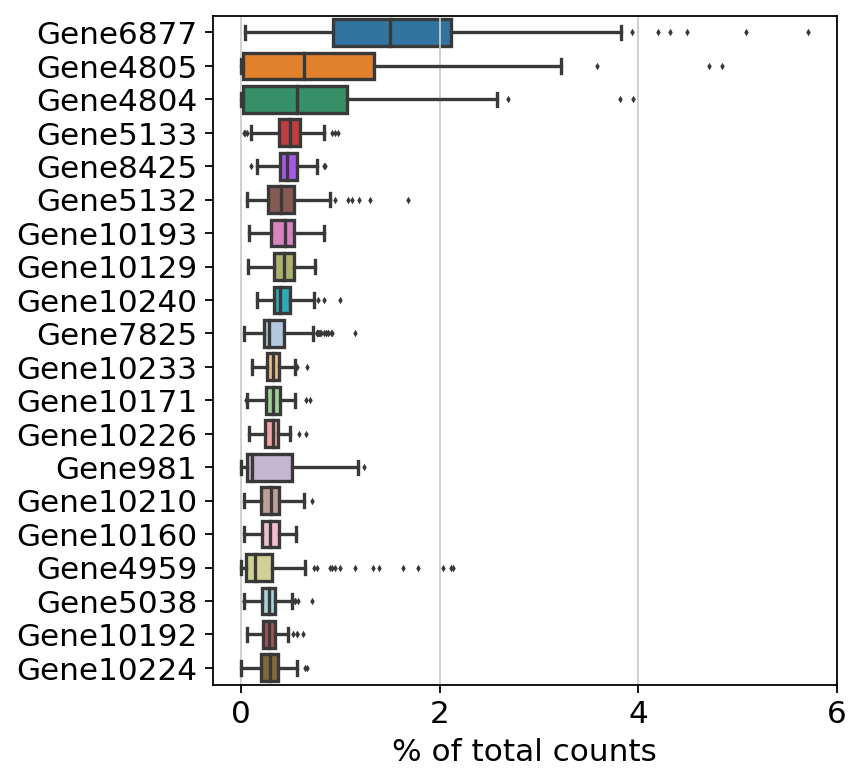

In [15]:
sc.pl.highest_expr_genes(adata, n_top=20, )

MALAT1 genes often masquerade as a "highly expressed gene" and tend to skew the results. Here, Gene6877 is assumed to be a MALAT1 gene.

In [16]:
# Filter out Gene6877, assuming that it is MALAT1 gene
gene_list = [name for name in adata.var_names if not name.startswith('Gene6877')]
adata = adata[:, gene_list]

#### Filter by total counts and number of genes

<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Count'>

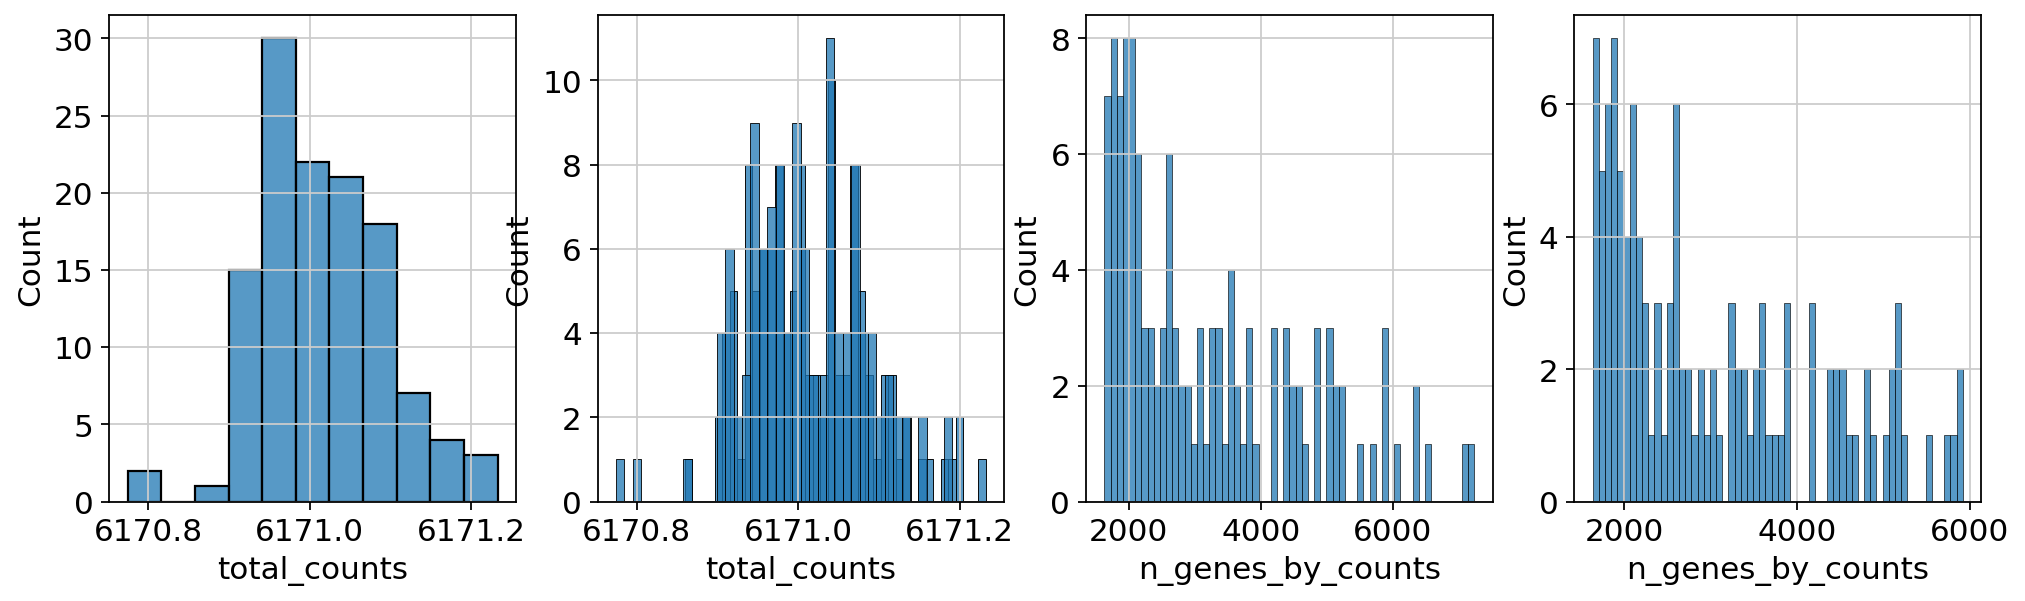

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] > 6170.8], kde=False, bins=40, ax=axs[1])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 6171.2], kde=False, bins=40, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 6000], kde=False, bins=60, ax=axs[3])

In [18]:
# Define outliers and filter
adata.obs["outlier_ngenes"] = adata.obs.n_genes_by_counts > 6000
adata.obs["outlier_total"] = adata.obs.total_counts < 6170.8
adata.obs["outlier_total"] += adata.obs.total_counts > 6171.2

print('%u cells with large number of genes' % (sum(adata.obs['outlier_ngenes'])))
print('%u cells with large total counts' % (sum(adata.obs['outlier_total'])))

adata = adata[~adata.obs['outlier_ngenes'], :]
adata = adata[~adata.obs['outlier_total'], :]

6 cells with large number of genes
4 cells with large total counts


/tmp/ipykernel_4430/3860109864.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["outlier_ngenes"] = adata.obs.n_genes_by_counts > 6000


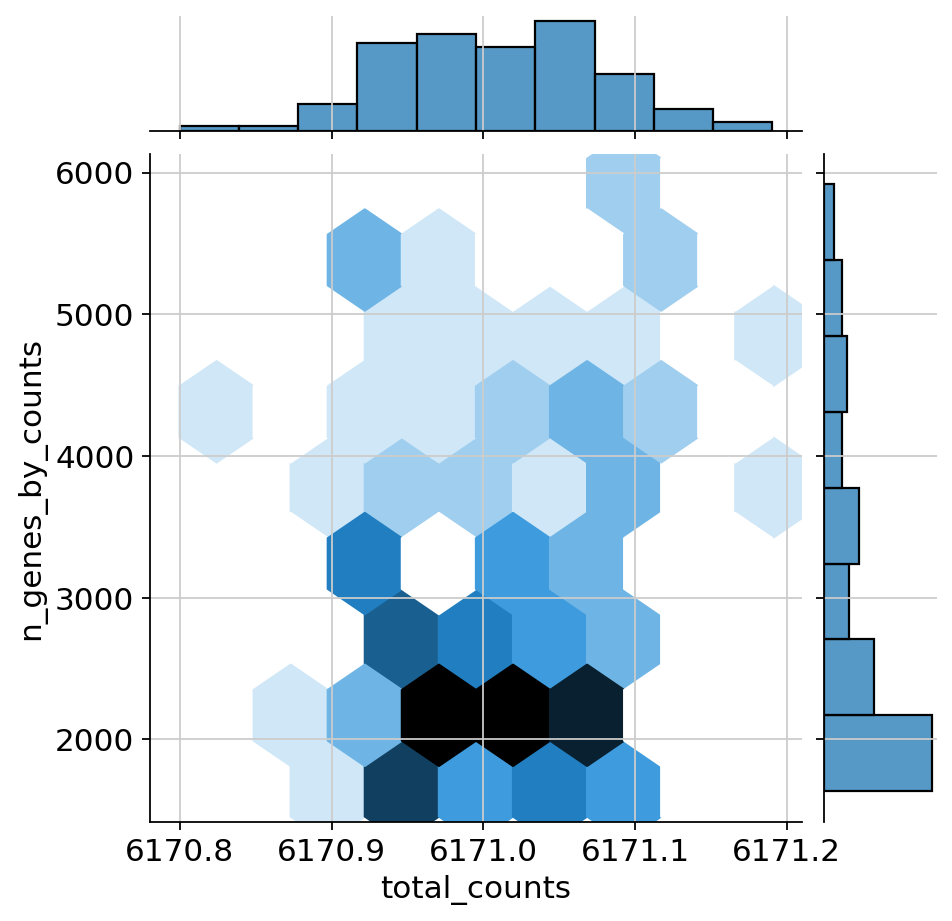

In [19]:
sns.jointplot(data=adata.obs, x="total_counts", y="n_genes_by_counts", kind="hex")

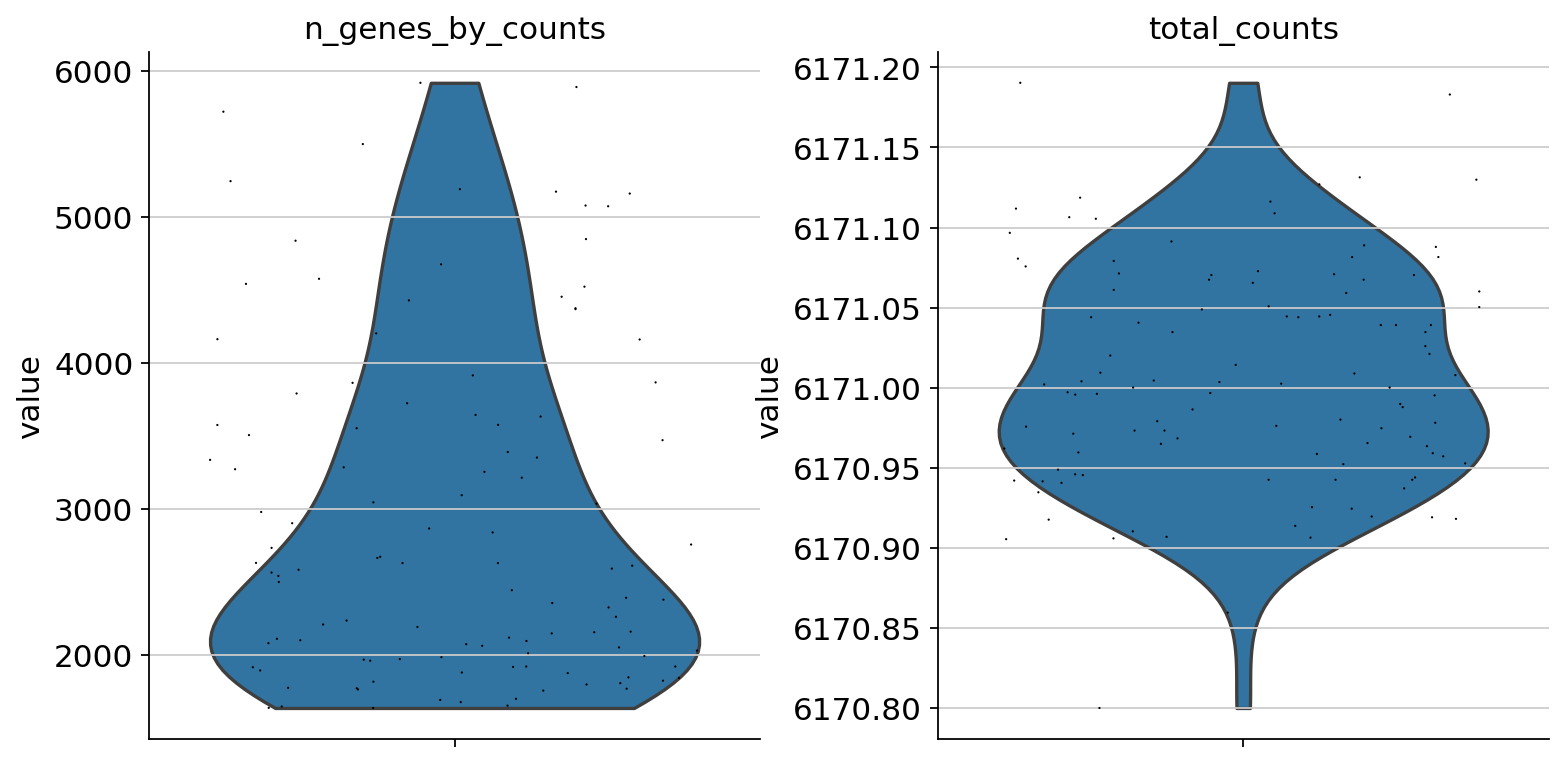

In [20]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts"], jitter=0.4, rotation= 45, multi_panel=True)

In [21]:
adata.raw = adata

## Hyperparameter tuning

### Find optimal number of PCs

The range of K values investigated is 1-20. 

The optimal number of PCs:

| Method | # PCs   |
|------|------|
|   Elbow method | 6|
|   Gap statistic  | 4|
|   Silhouette  |13 |



The chosen number of PCs is 10.

In [22]:
K = np.arange(2,20)

#### Elbow method

Here, the elbow plot shows that the optimal number of PCs is 10. However, this value contradicts with the findings of other methods (e.g., gap statistic, silhouette)

In [23]:
distortions = []

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

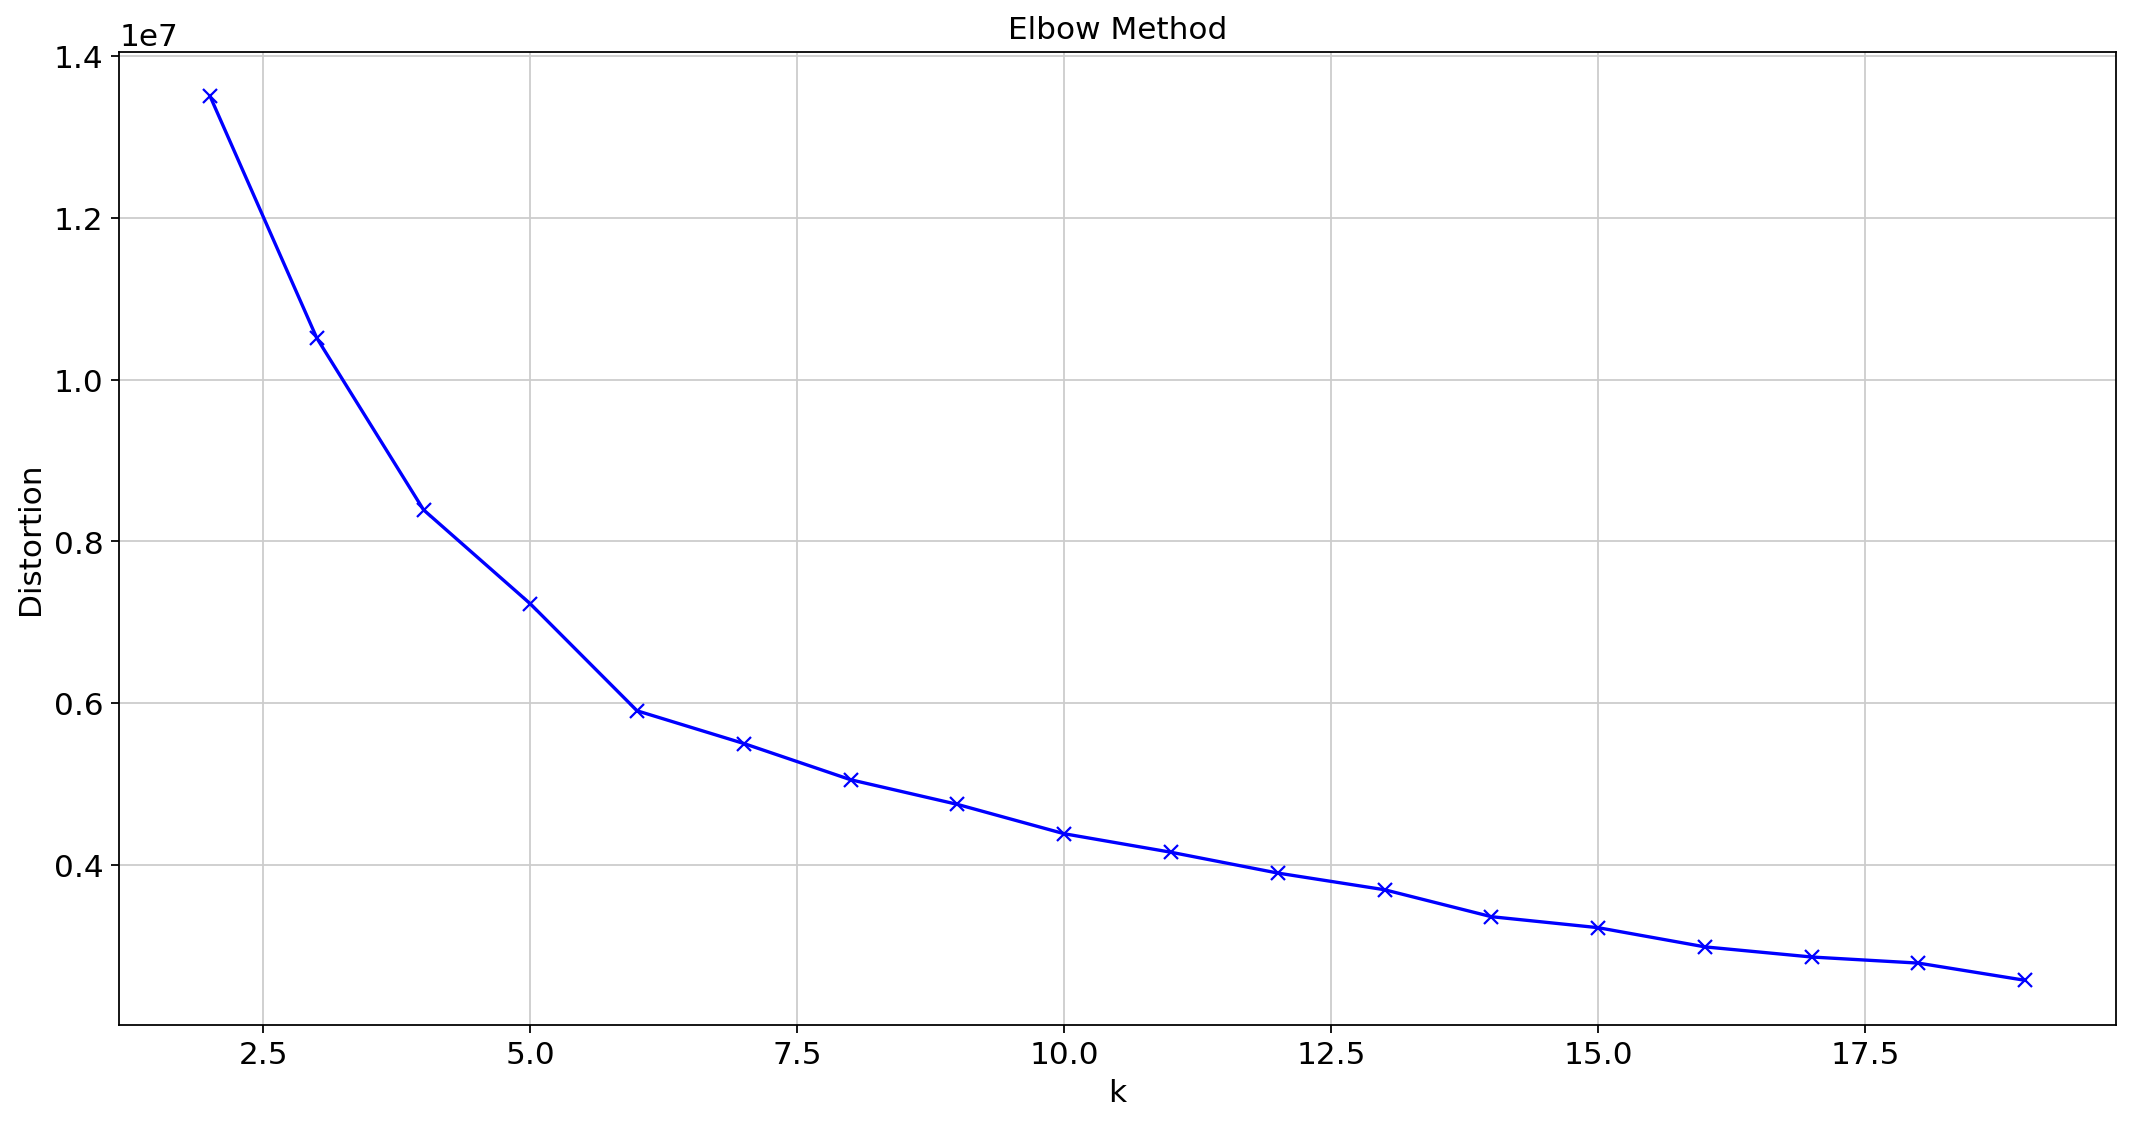

In [24]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

#### Gap Statistic

In [25]:
optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')
n_clusters = optimalK(df.astype("float"), cluster_array=K)

In [26]:
# The n_clusters that correspond to the smallest positive diff value is optimal, where diff = Gap(k) - Gap(k+1) + s(k+1)
min_pos = optimalK.gap_df.loc[optimalK.gap_df["diff"] > 0].min()['n_clusters']
min_pos

3.0

#### Silhouette score

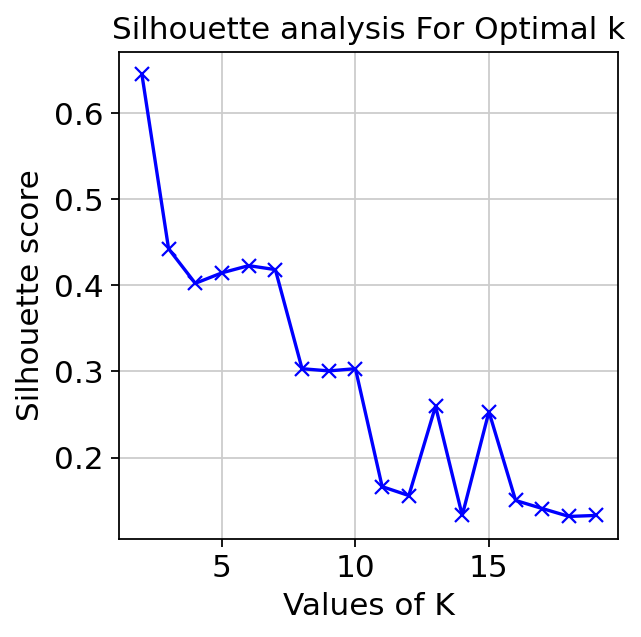

In [27]:
range_n_clusters = K
silhouette_avg = []
for n_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=n_clusters)
 kmeans.fit(df)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(df, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

### Find optimal n_neighbors

The optimal number of nearest neighbor is **5**, as defined by the squared row length divided by 2.

In [28]:
k = math.sqrt(len(df.index))/2
print('The optimal number of nearest neighbors, k, is %i' % k)

The optimal number of nearest neighbors, k, is 5


## Dimensionality reduction

Dimensionality reduction reduces the number of input variables (cells) in a dataset, thereby minimizing the curse of dimensionality. Fewer input dimensions often mean correspondingly fewer parameters (genes), thereby reducing the risk of overfitting the training dataset.

The dimensionality reduction techniques commonly used in single-cell RNA analysis include: <br>
- PCA (a type of matrix factorization) was applied to reduce the dimensionality of the data, revealing the main axes of variation and denoises the data.
- t-SNE (not strictly a dimensionality reduction technique because it does not preserve distances, but rather estimates probability distribution by mapping the input to a space of 2 or 3 dimensions)
- UMAP (can be used for similar visualization as t-SNE, but also for general non-linear dimensional reduction).

In [29]:
sc.pp.pca(adata, svd_solver='arpack')
sc.tl.tsne(adata, use_rep="X_pca", n_pcs=10)
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=10)
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  
sc.tl.umap(adata, init_pos='paga')
sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing tSNE
    using sklearn.manifold.TSNE


/home/melissachua/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


## Feature selection

### Leiden clustering of neighborhood graph

The Leiden algorithm is a community detection-based method. It connects communities via three phases:
1. Local moving of nodes
2. Refinement of the partition
3. Aggregation of the network based on the refined partition by using the non-refined partition to create an initial partition for the aggregate network.

**Time complexity:** Leiden algorithm seems to run in approximately linear time in a number of edges. It is faster than the Louvain algorithm because it has a smaller constant factor. Even at worst case, the run-time of Leiden algorithm remains near linear complexity.

In [30]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


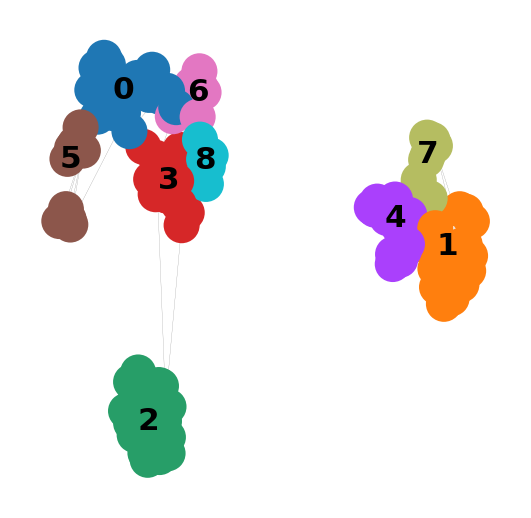

In [31]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf', edges=True)

### Differential expression

#### T-test

The simplest and fatest method to compute a ranking for the highly differential genes in each cluster is the t-test.



ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


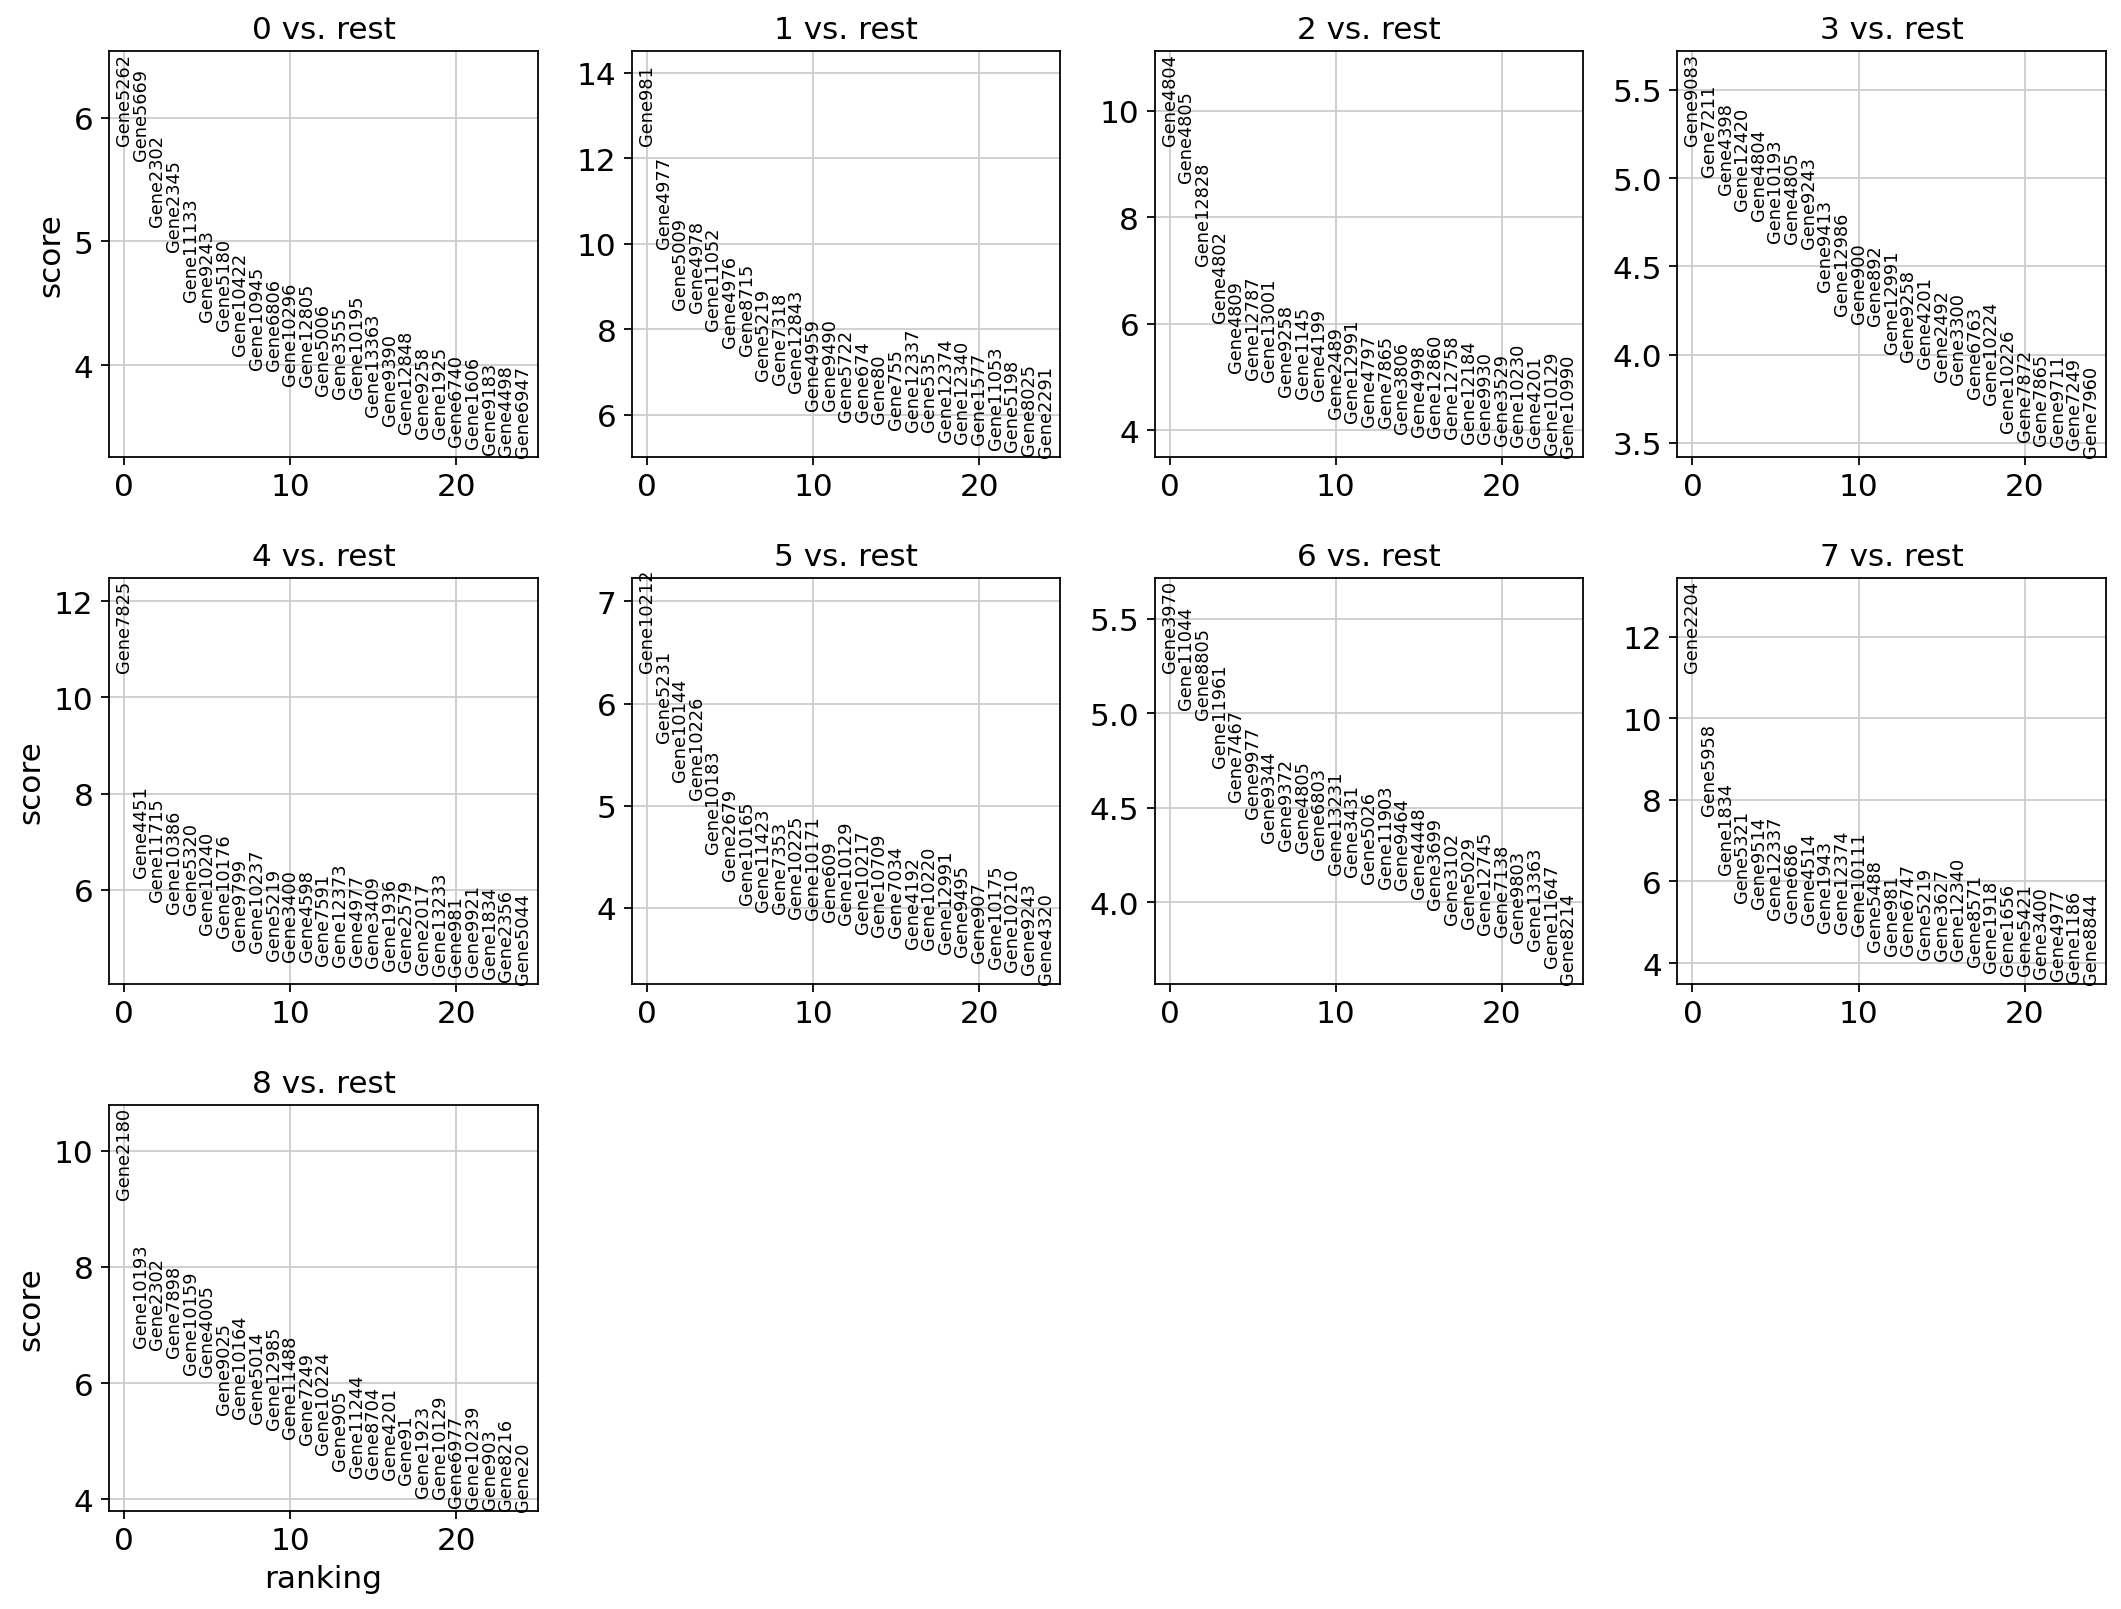

In [32]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [33]:
sc.settings.verbosity = 2  # reduce the verbosity

#### T-test overestimated_variance

ranking genes
    finished (0:00:00)


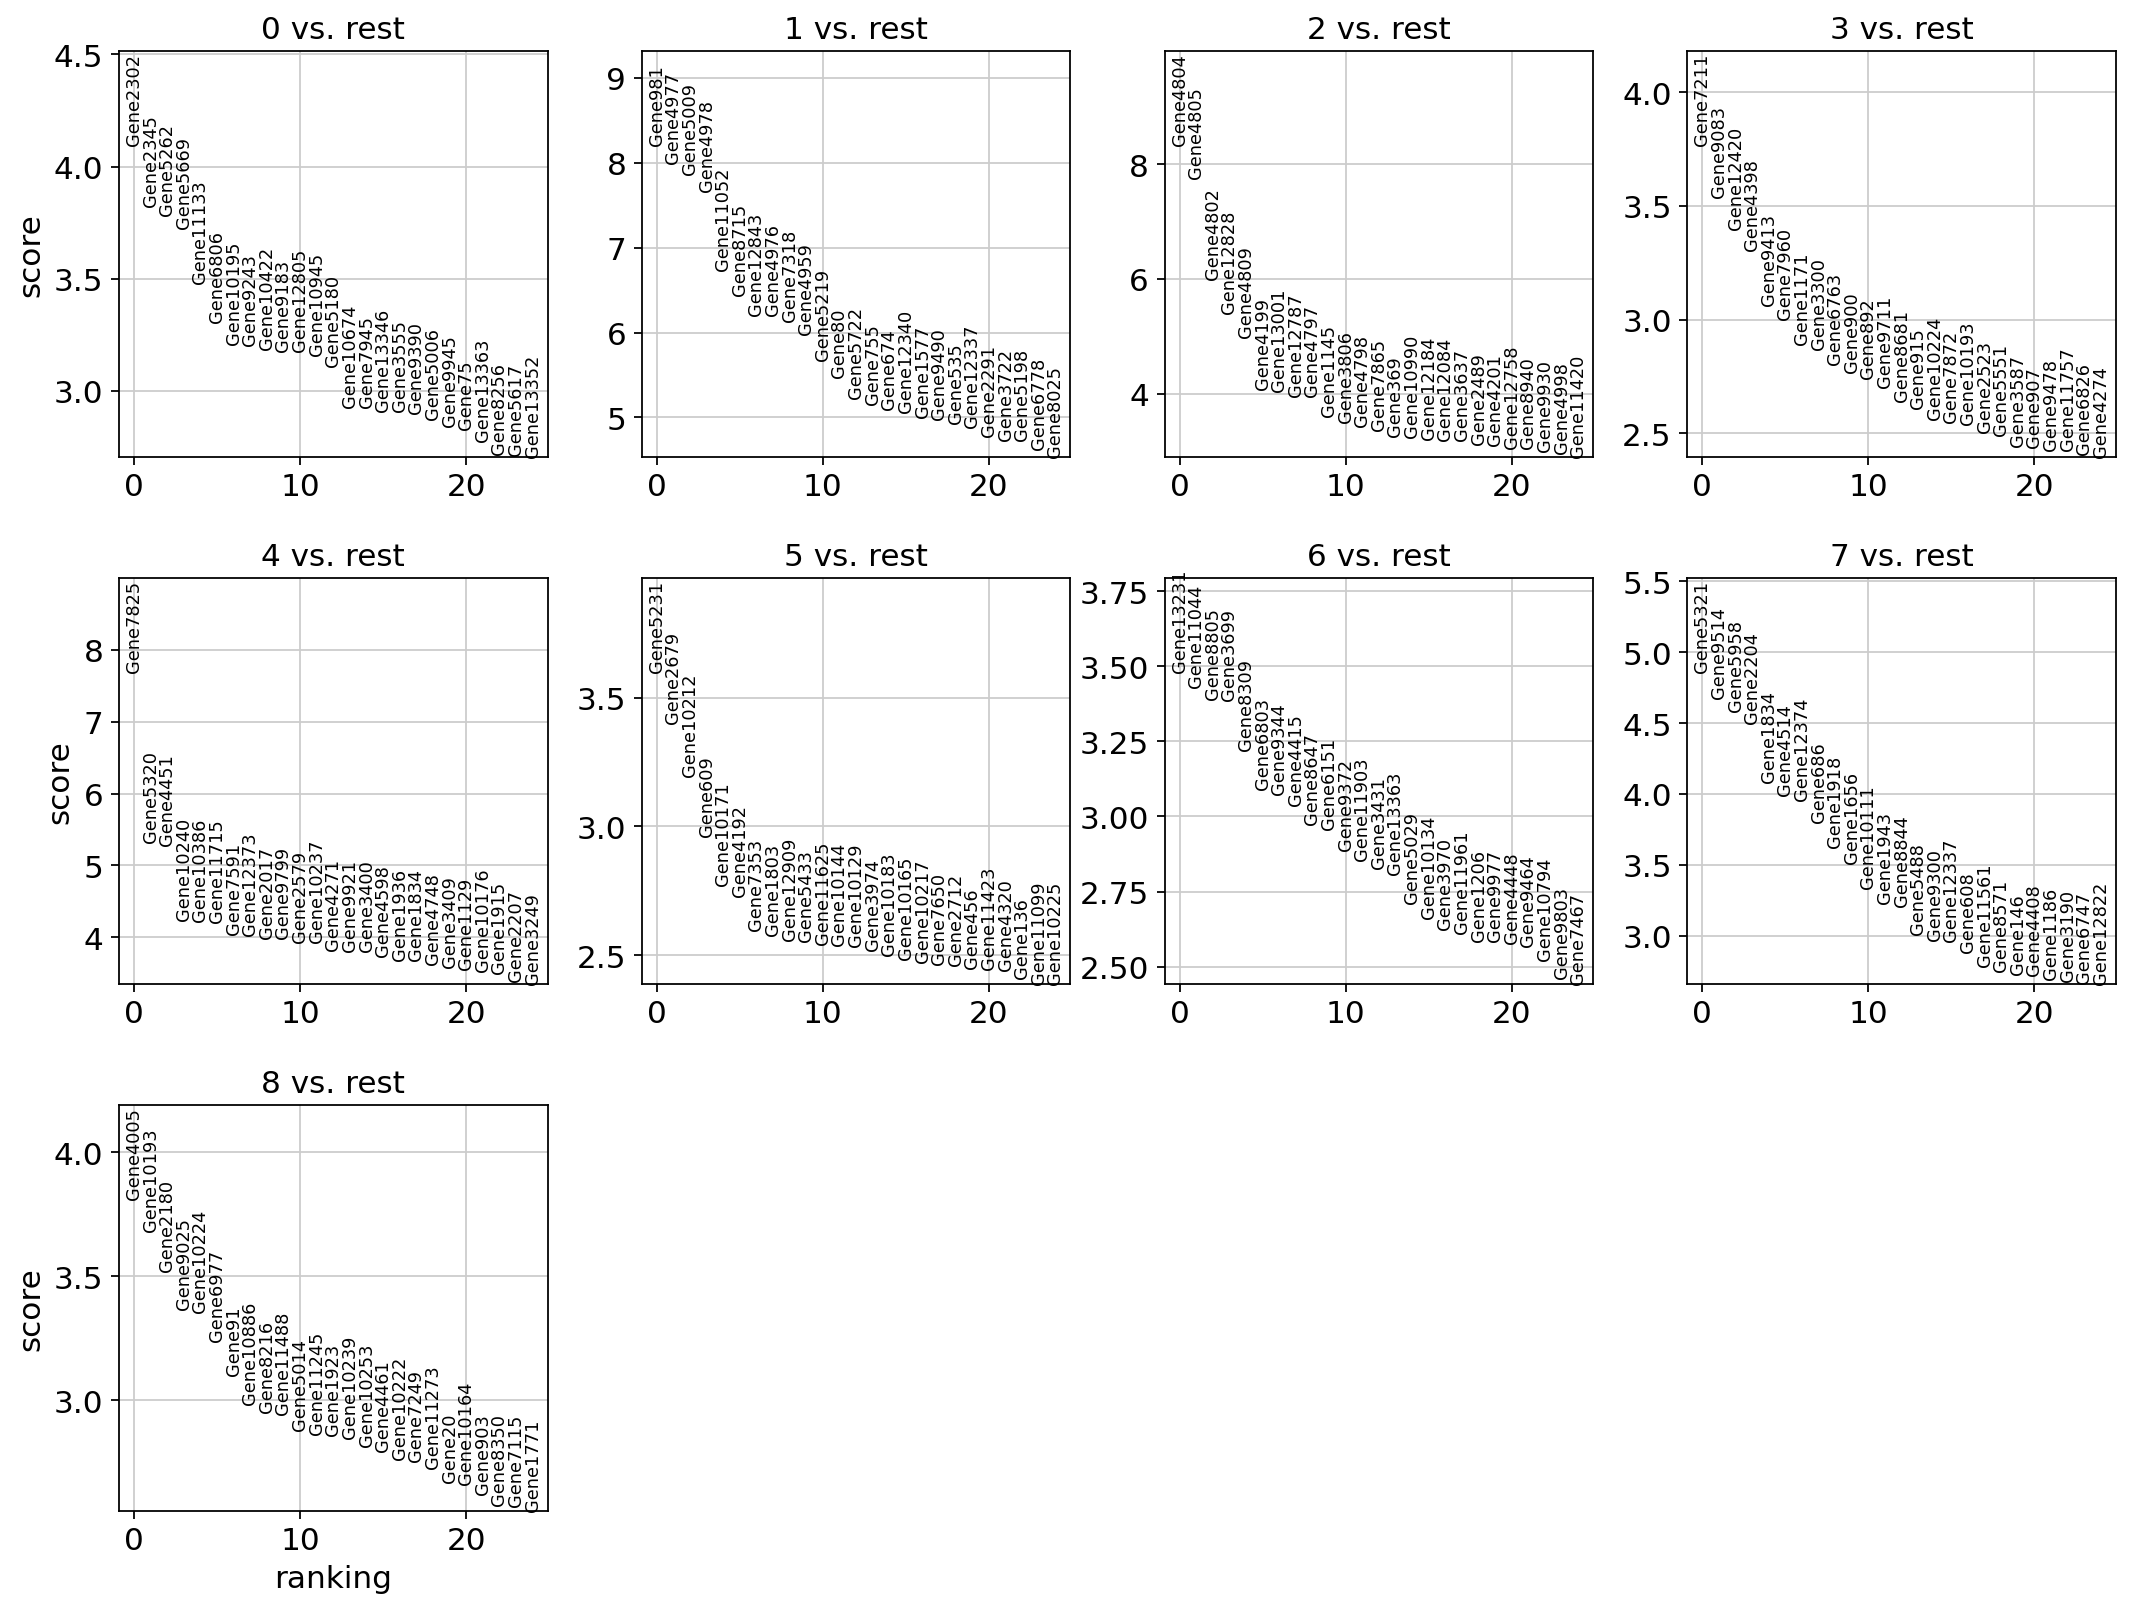

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test_overestim_var')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

#### Wilcoxon rank-sum test

The result of a Wilcoxon rank-sum test is very similar. 


ranking genes
    finished (0:00:00)


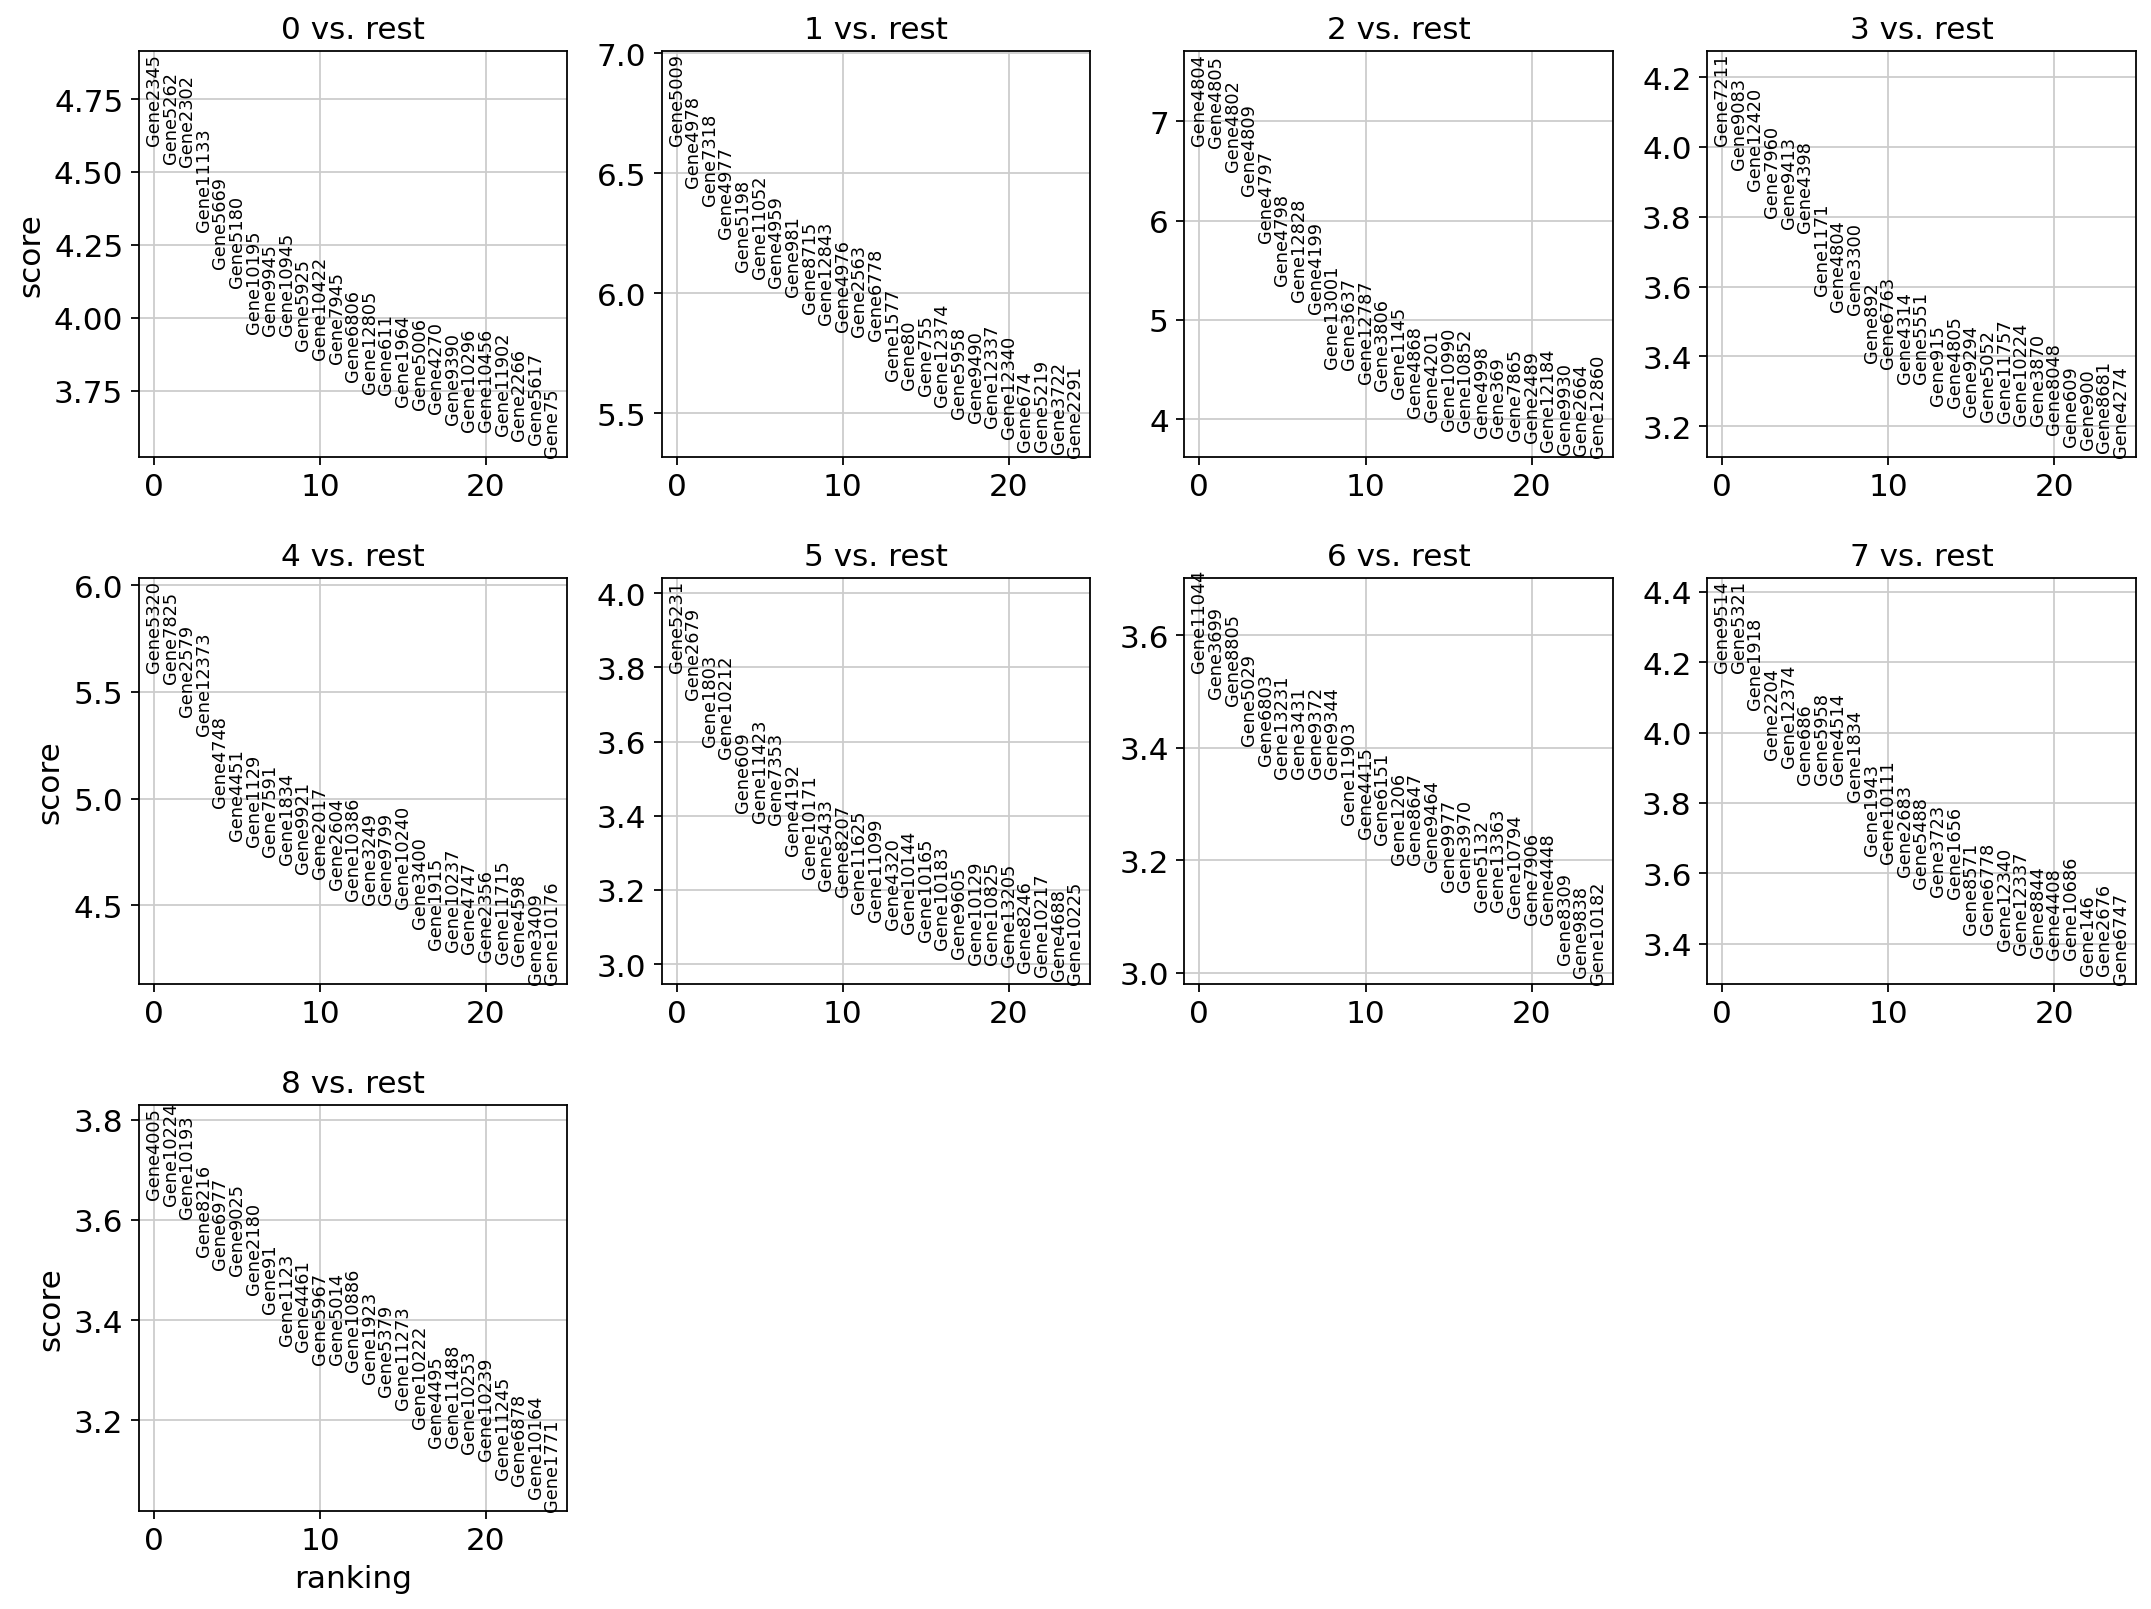

In [35]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [36]:
adata.write(results_file)

### Compare genes

Take all significant DE genes for cluster0 with each test and compare the overlap.

In [37]:
adata

AnnData object with n_obs × n_vars = 114 × 11129
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'outlier_ngenes', 'outlier_total', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'name', 'pca', 'tsne', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [38]:
adata = sc.read(results_file)

Show the 5 top ranked genes per cluster 0, 1, …, 9 in a dataframe.

In [39]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0         1         2          3          4          5          6  \
0   Gene2345  Gene5009  Gene4804   Gene7211   Gene5320   Gene5231  Gene11044   
1   Gene5262  Gene4978  Gene4805   Gene9083   Gene7825   Gene2679   Gene3699   
2   Gene2302  Gene7318  Gene4802  Gene12420   Gene2579   Gene1803   Gene8805   
3  Gene11133  Gene4977  Gene4809   Gene7960  Gene12373  Gene10212   Gene5029   
4   Gene5669  Gene5198  Gene4797   Gene9413   Gene4748    Gene609   Gene6803   

           7          8  
0   Gene9514   Gene4005  
1   Gene5321  Gene10224  
2   Gene1918  Gene10193  
3   Gene2204   Gene8216  
4  Gene12374   Gene6977

Get a table with the scores and groups.

In [40]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n       0_p       1_n           1_p       2_n           2_p  \
0   Gene2345  0.000004  Gene5009  3.624021e-11  Gene4804  1.350228e-11   
1   Gene5262  0.000006  Gene4978  1.165100e-10  Gene4805  1.580158e-11   
2   Gene2302  0.000006  Gene7318  1.917862e-10  Gene4802  7.788084e-11   
3  Gene11133  0.000017  Gene4977  4.637089e-10  Gene4809  3.817039e-10   
4   Gene5669  0.000030  Gene5198  1.100833e-09  Gene4797  7.041747e-09   

         3_n       3_p        4_n           4_p        5_n       5_p  \
0   Gene7211  0.000062   Gene5320  2.218869e-08   Gene5231  0.000152   
1   Gene9083  0.000083   Gene7825  3.015760e-08   Gene2679  0.000204   
2  Gene12420  0.000106   Gene2579  7.086322e-08   Gene1803  0.000333   
3   Gene7960  0.000145  Gene12373  1.159163e-07  Gene10212  0.000375   
4   Gene9413  0.000164   Gene4748  7.010941e-07    Gene609  0.000650   

         6_n       6_p        7_n       7_p        8_n       8_p  
0  Gene11044  0.000408   Gene9514  0.000030   Gene4005  0.000271  
1   Gene3699  0.000487   Gene5321  0.000030  Gene10224  0.000284  
2   Gene8805  0.000509   Gene1918  0.000048  Gene10193  0.000313  
3   Gene5029  0.000661   Gene2204  0.000087   Gene8216  0.000419  
4   Gene6803  0.000752  Gene12374  0.000096   Gene6977  0.000461

In [41]:
new_cluster_names = ["Clust0","Clust1","Clust2","Clust3","Clust4","Clust5","Clust6","Clust7", "Clust8"]
adata.rename_categories('leiden', new_cluster_names)

/home/melissachua/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


#### Get the top 20 genes in the clusters

normalizing counts per cell
    finished (0:00:00)


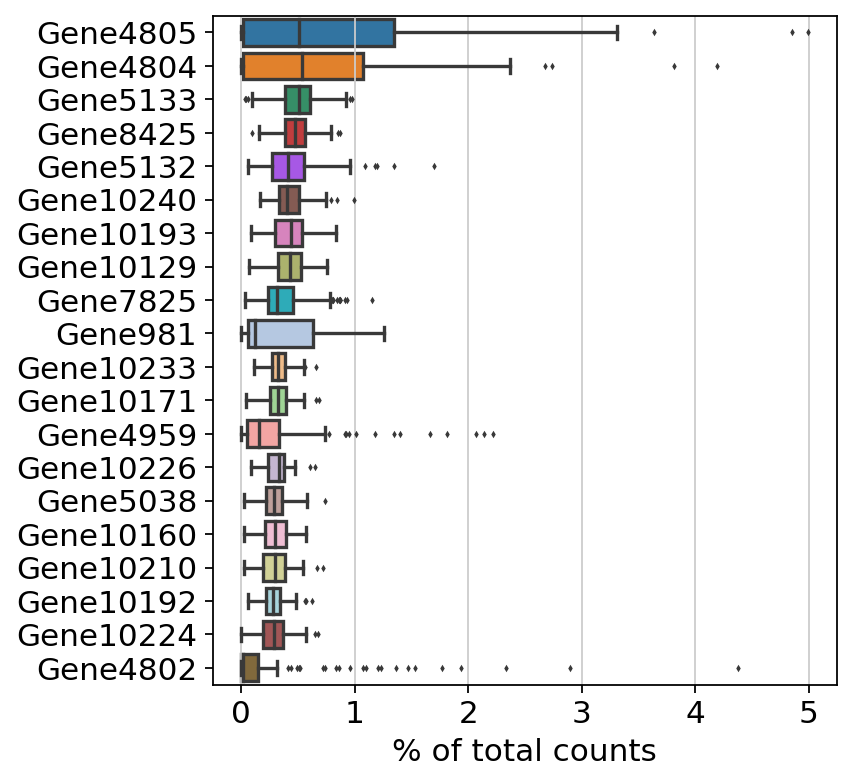

In [42]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [43]:
top20 = ["Gene4805", "Gene4804", "Gene5133", "Gene8425", "Gene5132", "Gene10193", "Gene10129", "Gene10240", "Gene7825", "Gene10233", "Gene10171", "Gene10226", "Gene981", "Gene10210", "Gene10160", "Gene4959", "Gene5038", "Gene10192", "Gene10224", "Gene4802"]
print('The top 20 genes are: %s' % top20)

The top 20 genes are: ['Gene4805', 'Gene4804', 'Gene5133', 'Gene8425', 'Gene5132', 'Gene10193', 'Gene10129', 'Gene10240', 'Gene7825', 'Gene10233', 'Gene10171', 'Gene10226', 'Gene981', 'Gene10210', 'Gene10160', 'Gene4959', 'Gene5038', 'Gene10192', 'Gene10224', 'Gene4802']


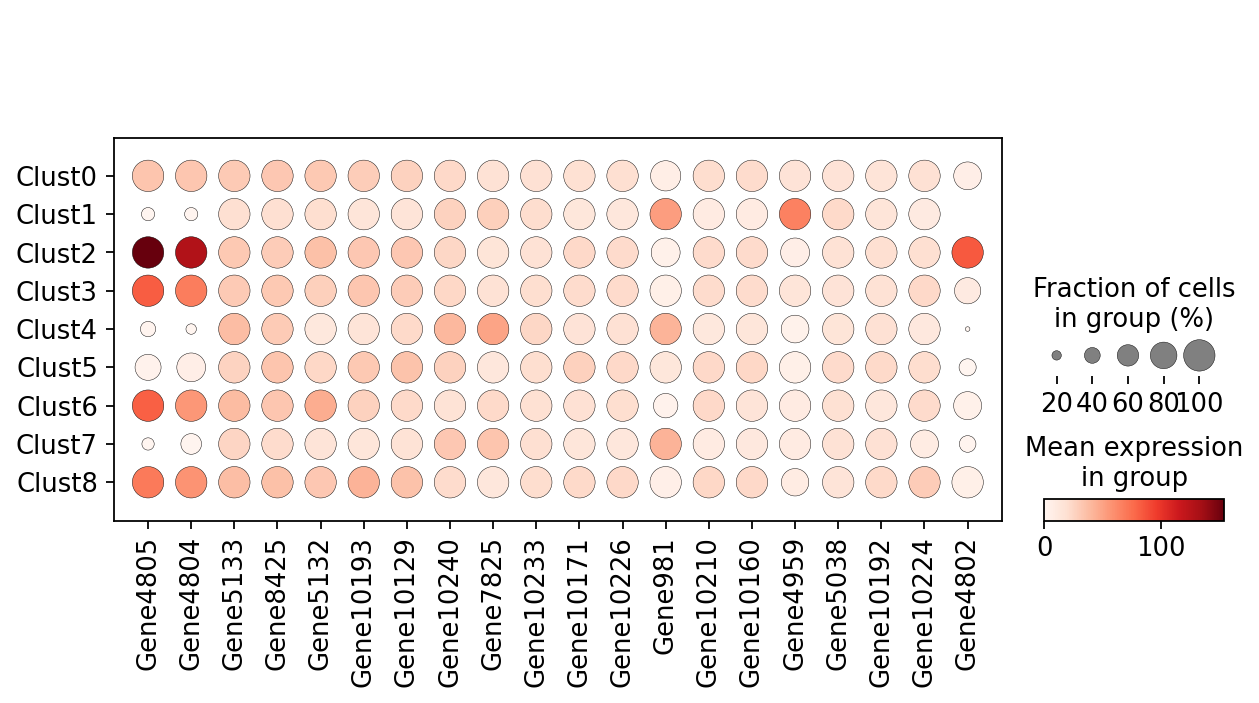

In [44]:
sc.pl.dotplot(adata, top20, groupby='leiden')

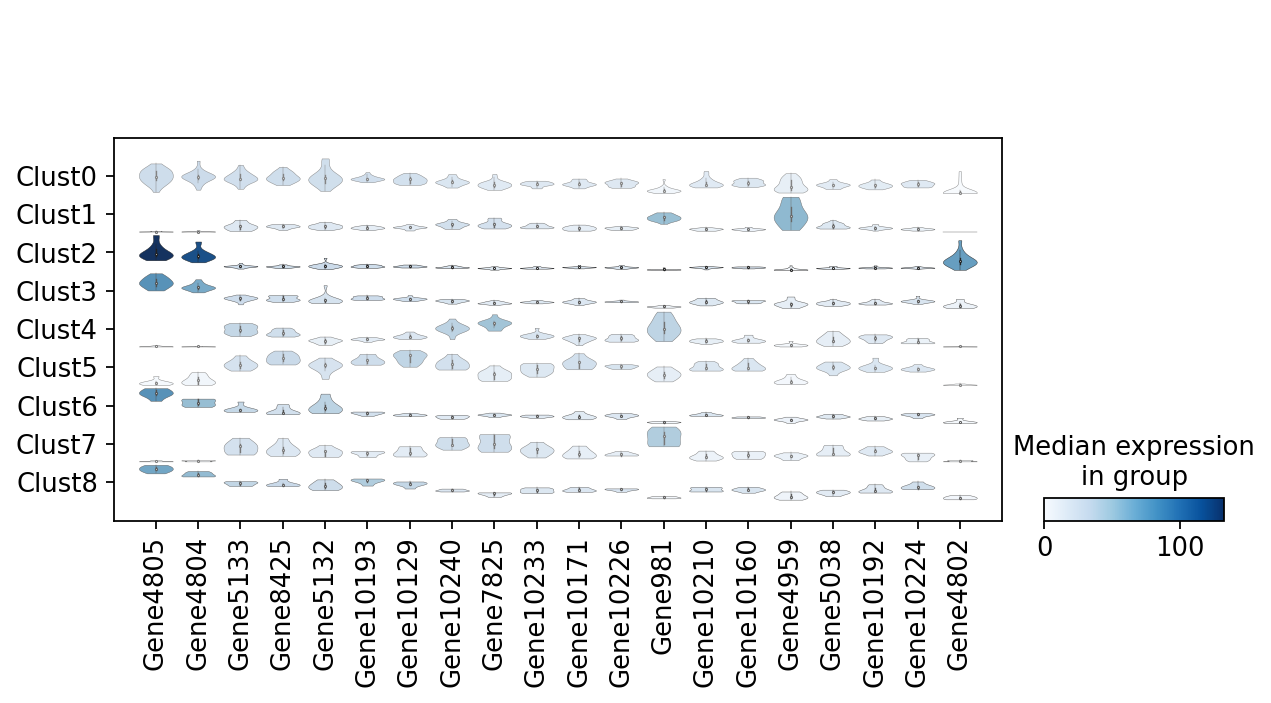

In [45]:
sc.pl.stacked_violin(adata, top20, groupby='leiden', rotation=90, inner='box')

There are ten gene clusters. 

Gene6877, as expected, is highly expressed in all the clusters and is potentially a mitochondrial gene as mentioned previously; if it is truly a mitochondrial gene, a high proportion of this gene indicates poor-quality cells and should therefore be filtered from the dataset. 

Based on the dot plot and stacked violin plot, Gene4805 is differentially expressed in 6 out of 10 clusters; upgregulated in Cluster2, Cluster4, Cluster5, while downregulated in Cluster3, Cluster6, and Cluster9. Gene4804 is differentially expressed in 4 out of 10 clusters; upregulated in Cluster2, Cluster4, Cluster5, while downregulated in Cluster9. Both Gene4805 and Gene4804 demonstrate similar expression trends for Cluster2, Cluster4, Cluster5, and Cluster9. However, unlike Gene4805, Cluster3, and Cluster6 did not show any differential expression (upregulation/downregulation) despite being significantly expressed in a large fraction of cells within the clusters. One possible explanation is that Cluster3 and Cluster6 comprise of non-coding genes or genes that have dichotomous (or multiphasic) expression in response to molecular switches (i.e., microenvironmental stimuli such as immune modulation, metabolism, hormone regulation, autophagy). 

In [46]:
adata

AnnData object with n_obs × n_vars = 114 × 11129
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'outlier_ngenes', 'outlier_total', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'leiden', 'leiden_colors', 'leiden_sizes', 'name', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [47]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

#### Pearson residuals for selection of highly variable genes

In [48]:
sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=100)

extracting highly variable genes


/home/melissachua/anaconda3/lib/python3.9/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:73: UserWarning: `flavor='pearson_residuals'` expects raw count data, but non-integers were found.
  warnings.warn(


In [49]:
# Identify hypothetical markers
top = adata.var.sort_values("highly_variable_rank").dropna().head(5) 
bottom = adata.var.sort_values("highly_variable_rank").dropna().tail(5)
diff = pd.concat([top, bottom])
markers = diff.index

Considering that information such as cell/tissue origin, gene names, biomarker list, and phenotypes are not provided, the top and bottom 5 "highly_variable_rank" genes were superficially selected as biomarkers. 

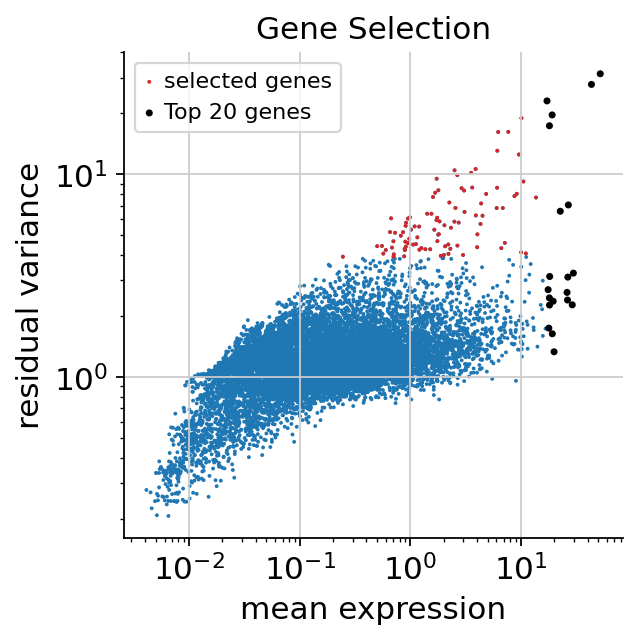

In [50]:
# Plot gene selection

hvgs = adata.var["highly_variable"]


plt.scatter(adata.var["mean_counts"], adata.var["residual_variances"], s=3, edgecolor="none")
plt.scatter(adata.var["mean_counts"][hvgs],adata.var["residual_variances"][hvgs],c="tab:red", label="selected genes", s=3, edgecolor="none")
plt.scatter(adata.var["mean_counts"][np.isin(adata.var_names, top20)], adata.var["residual_variances"][np.isin(adata.var_names, top20)], c="k", label="Top 20 genes", s=10, edgecolor="none")

plt.xscale("log")
plt.xlabel("mean expression")
plt.yscale("log")
plt.ylabel("residual variance")
plt.title("Gene Selection")

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().yaxis.set_ticks_position("left")
plt.gca().xaxis.set_ticks_position("bottom")

plt.legend(prop={"size":10})

In [51]:
# Apply gene selection
adata = adata[:, adata.var["highly_variable"]]

In [52]:
adata.write(results_file, compression='gzip')

#### Z-score transformation

In [53]:
# Compute Pearson residuals
adata.layers["raw"] = adata.X.copy()
adata.layers["sqrt_norm"] = np.sqrt(sc.pp.normalize_total(adata, inplace=False)["X"])
sc.experimental.pp.normalize_pearson_residuals(adata)

normalizing counts per cell
    finished (0:00:00)
computing analytic Pearson residuals on adata.X
    finished (0:00:00)


/home/melissachua/anaconda3/lib/python3.9/site-packages/scanpy/experimental/pp/_normalization.py:43: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.
  warn(


#### PCA plot

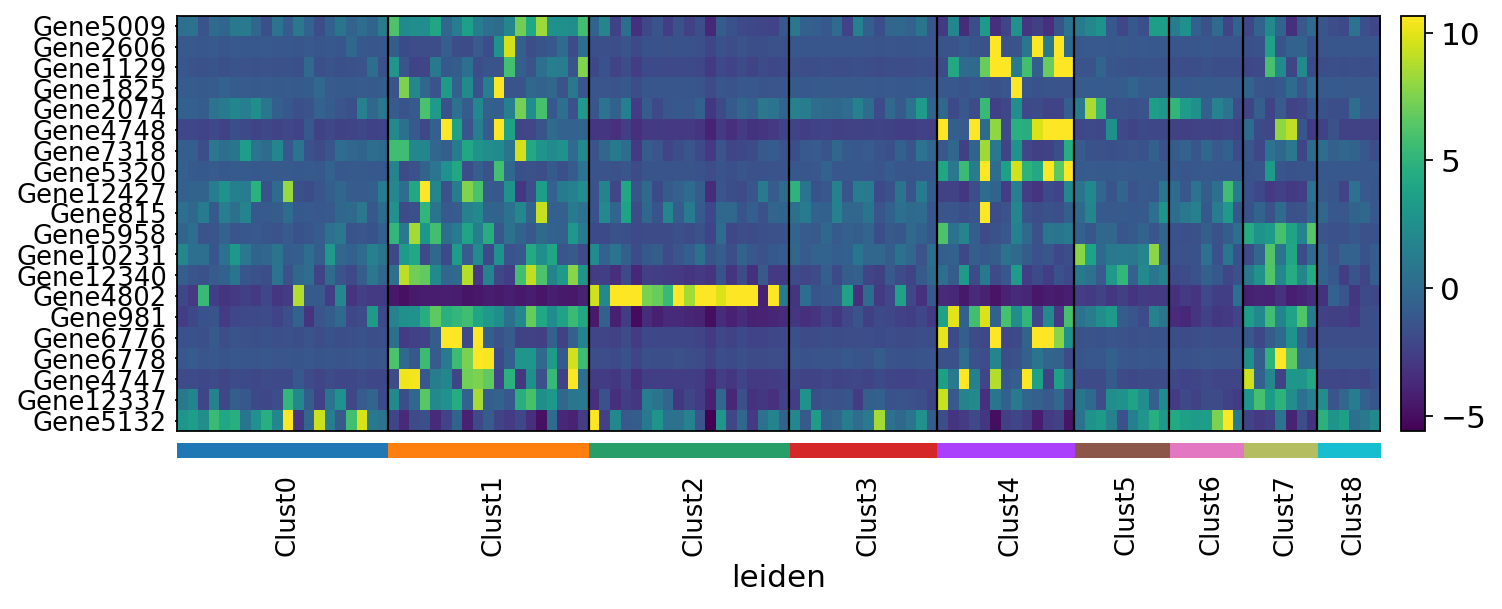

In [54]:
# Plot as a heatmap, with genes on both postive and negative side, one per pc, and plot their expression amongst cells ordered by their position along the pc
# adata.obsm["X_pca"] is the embeddings
# adata.uns["pca"] is pc variance
# adata.varm['PCs'] is the loadings

genes = adata.var_names
n_pcs = 10

g = adata.varm['PCs'][:,n_pcs-1]
o = np.argsort(g)
sel = np.concatenate((o[:10],o[-10:])).tolist()
emb = adata.obsm['X_pca'][:,n_pcs-1]
tempdata = adata[np.argsort(emb),]
sc.pl.heatmap(tempdata, var_names = genes[sel].tolist(), groupby='leiden', swap_axes = True, use_raw=False)

In [55]:
#sc.pl.pca_variance_ratio(adata, log=True, n_pcs=10)

Based on PCA variance plot, all the PCs retain relatively homogenous amount of information, with the top 2 PCs retaining slightly more information than the rest.

**Time complexity:** The overall complexity of PCA is $O(p^{2}n+p^{3})$ because the covariance matrix computation is $O(p^{2}n)$ and the eigenvalue decomposition is $O(p^{3})$. The worst case complexity is $O(p^{3})$

**Space complexity:** The space complexity of PCA is $O(p^{2})$ 

#### tSNE plot

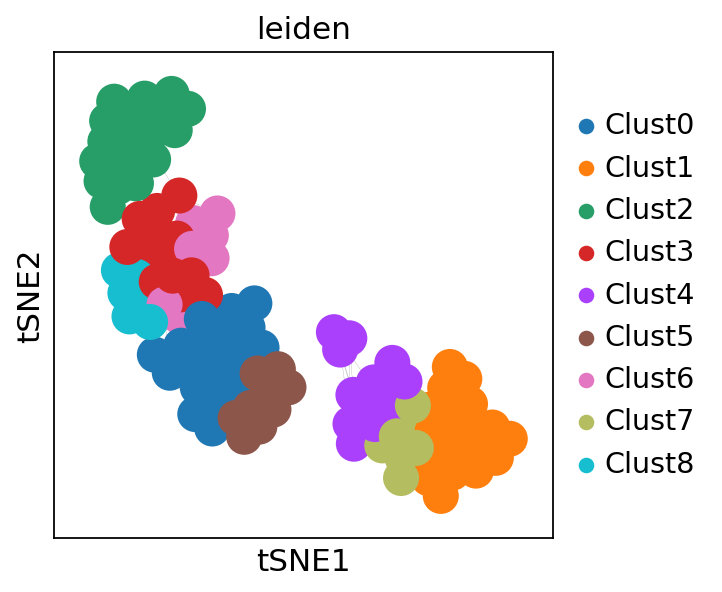

In [56]:
# Plot Leiden clusters on tSNE and marker genes
sc.pl.tsne(adata, color=["leiden"], cmap="tab20", edges=True)
#sc.pl.tsne(adata, color=markers, layer="sqrt_norm", legend_loc='on data')

**Time complexity**: The overall and worst case complexity of tSNE algorithm is $O(N^{2})$

**Space complexity:** The space complexity of tSNE algorithm is $O(N^{2})$

#### UMAP

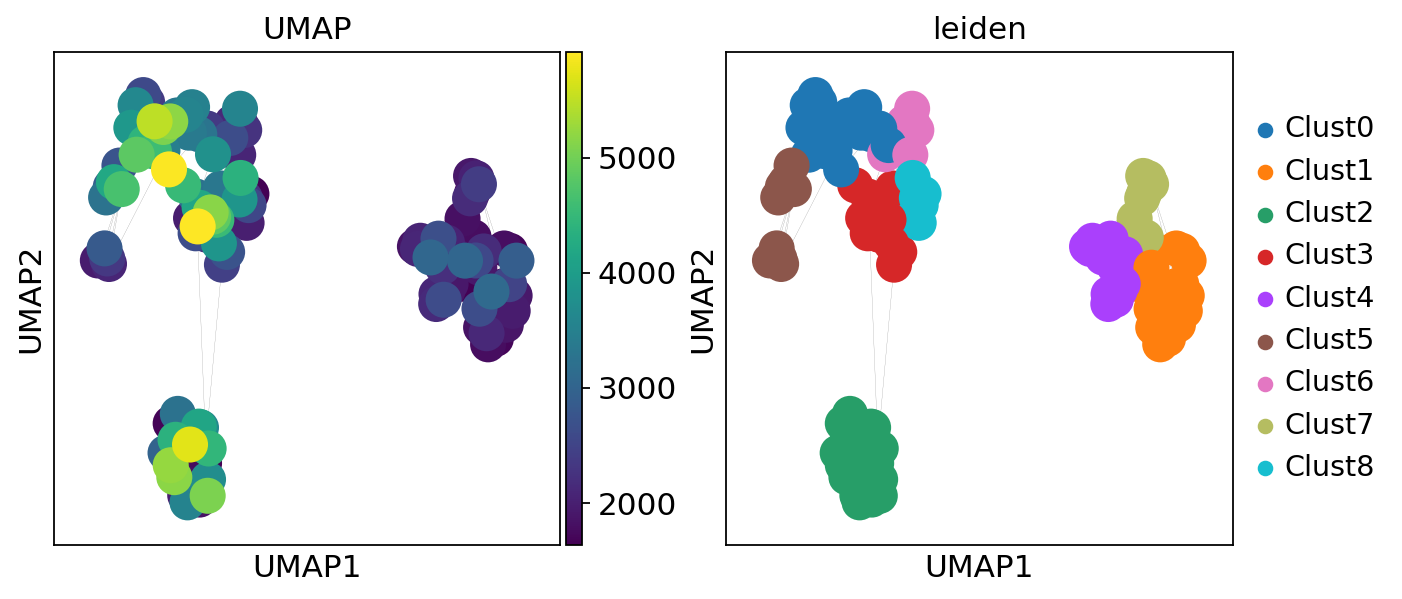

In [57]:
# PLot umap
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["n_genes_by_counts", "leiden"], title="UMAP", edges=True)

#### Plot genes of interest

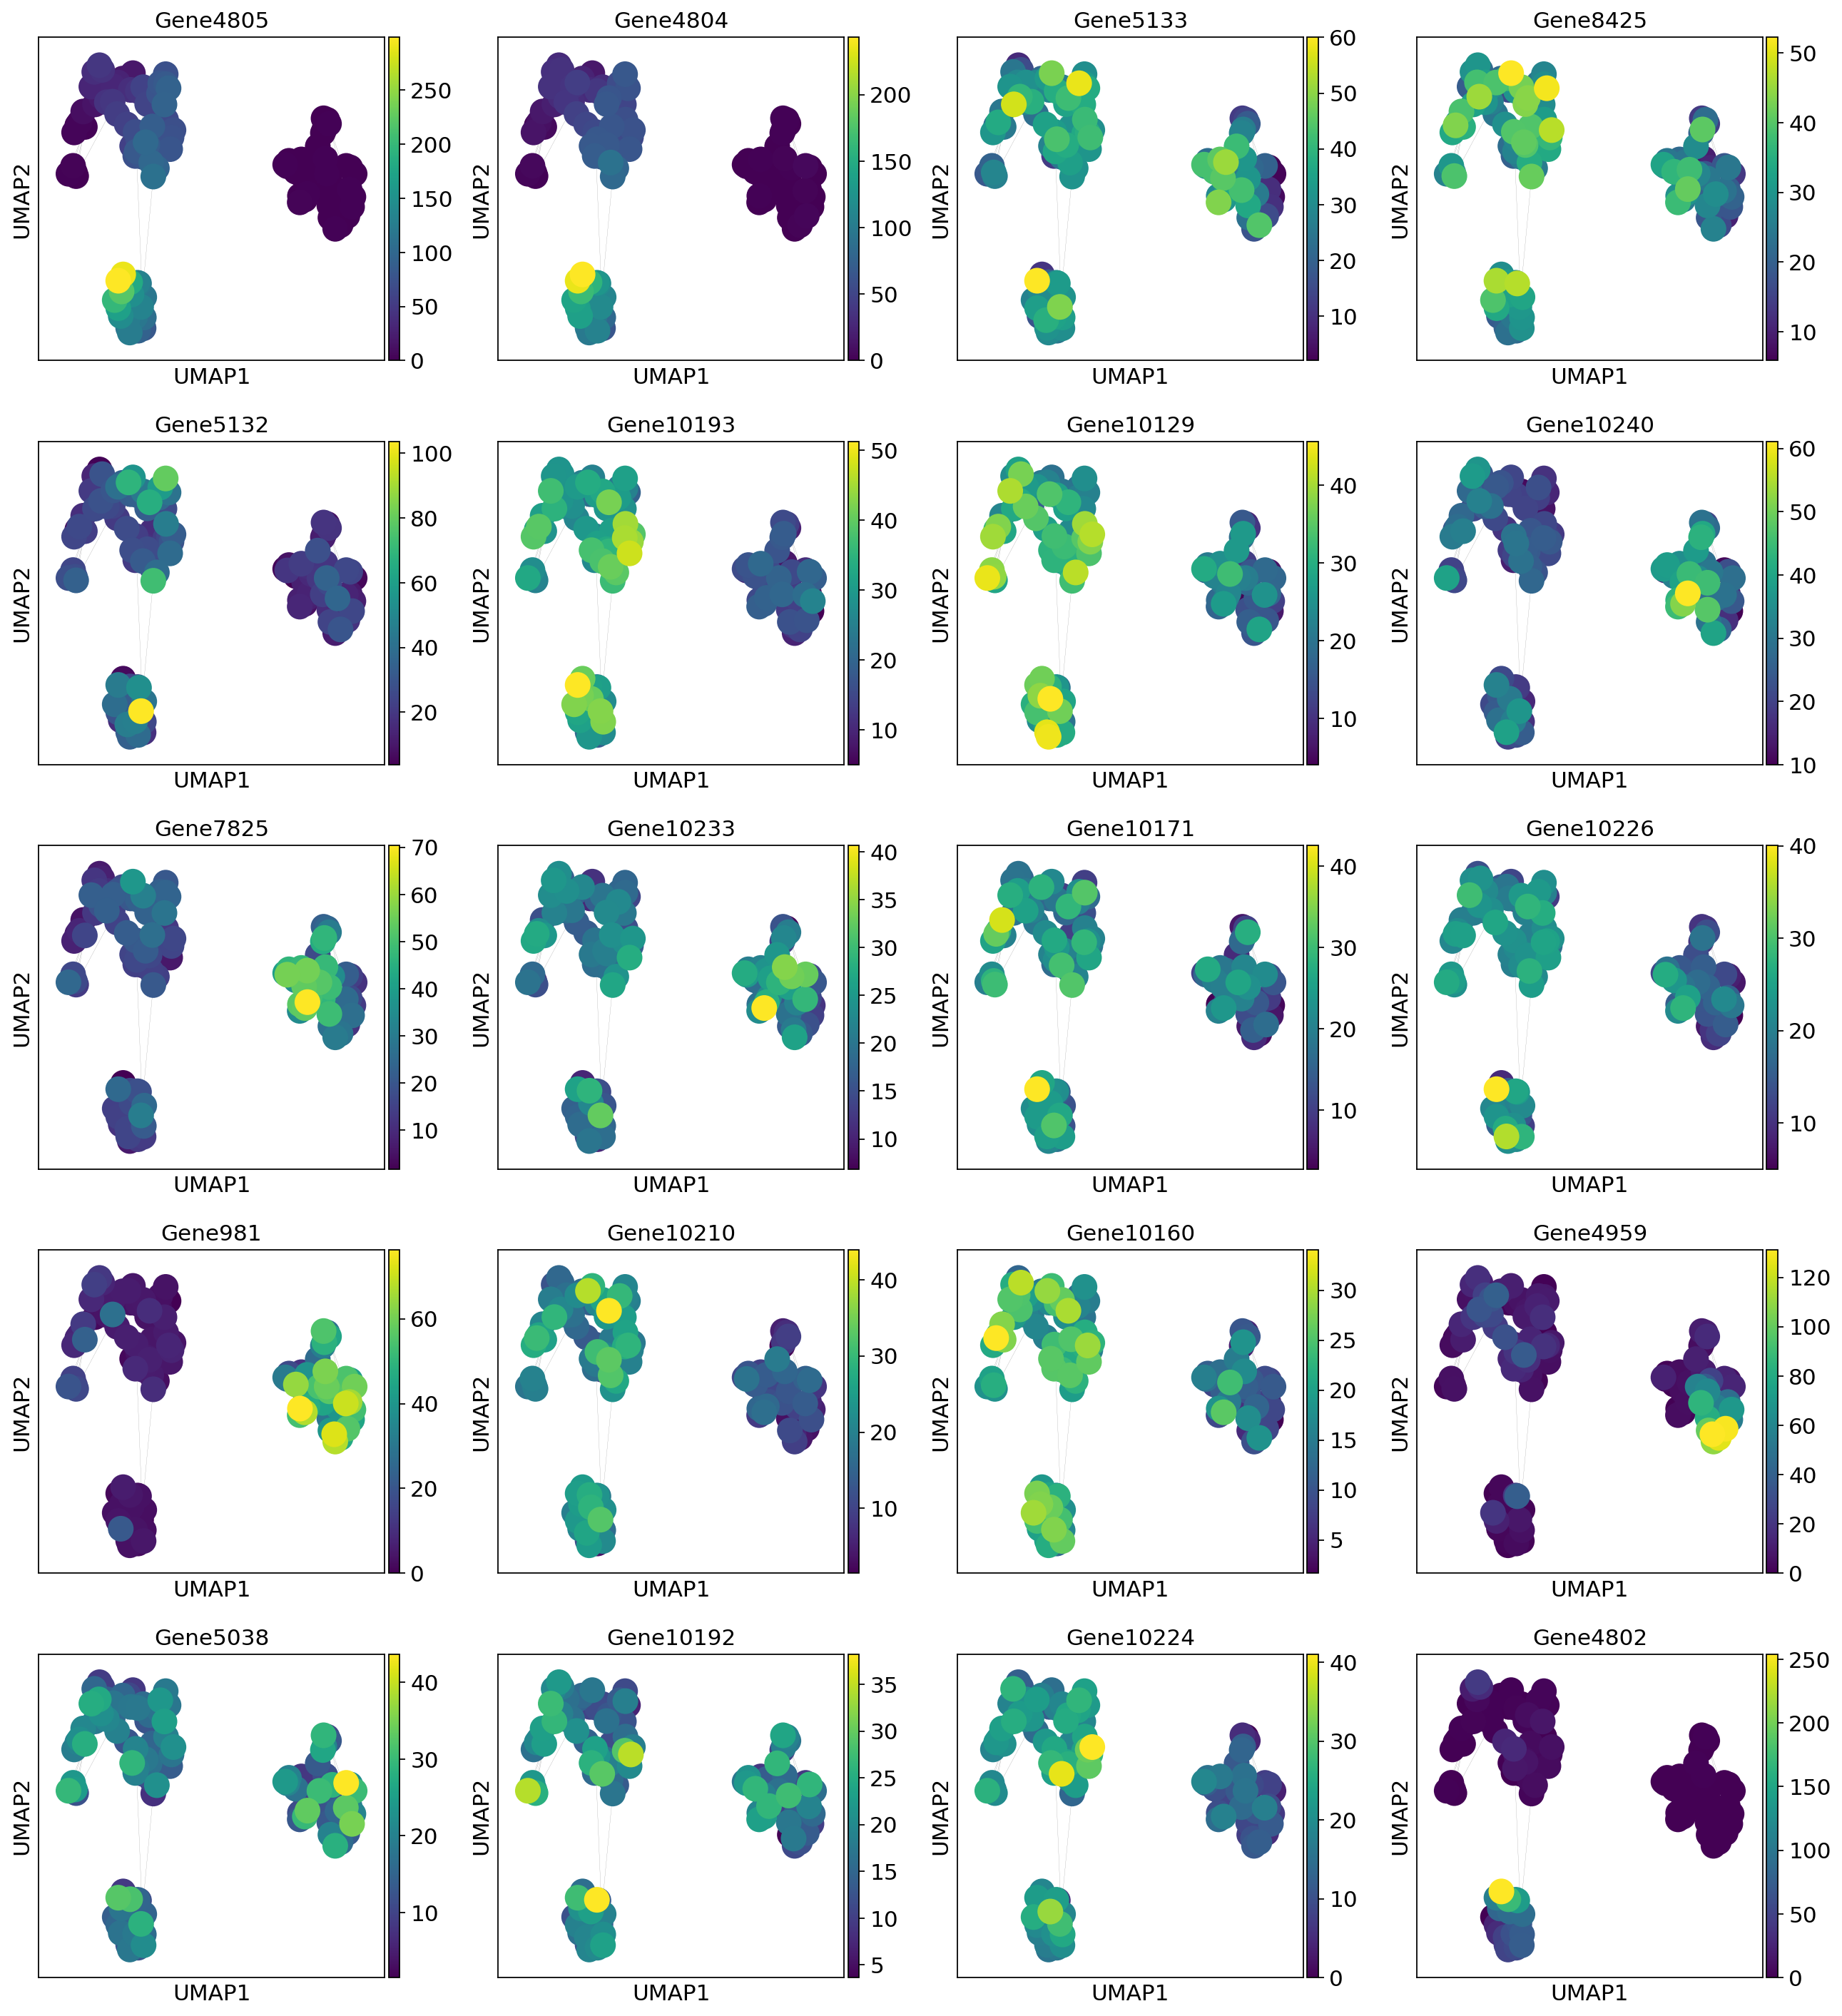

In [58]:
sc.pl.umap(adata, color=top20, edges=True)

The default is to plot gene expression in the normalized and log-transformed data. Below, gene expression is plotted on scaled and corrected data by using use_raw=False. However, not all of these genes are included in the variable gene set so it needs to be filtered.

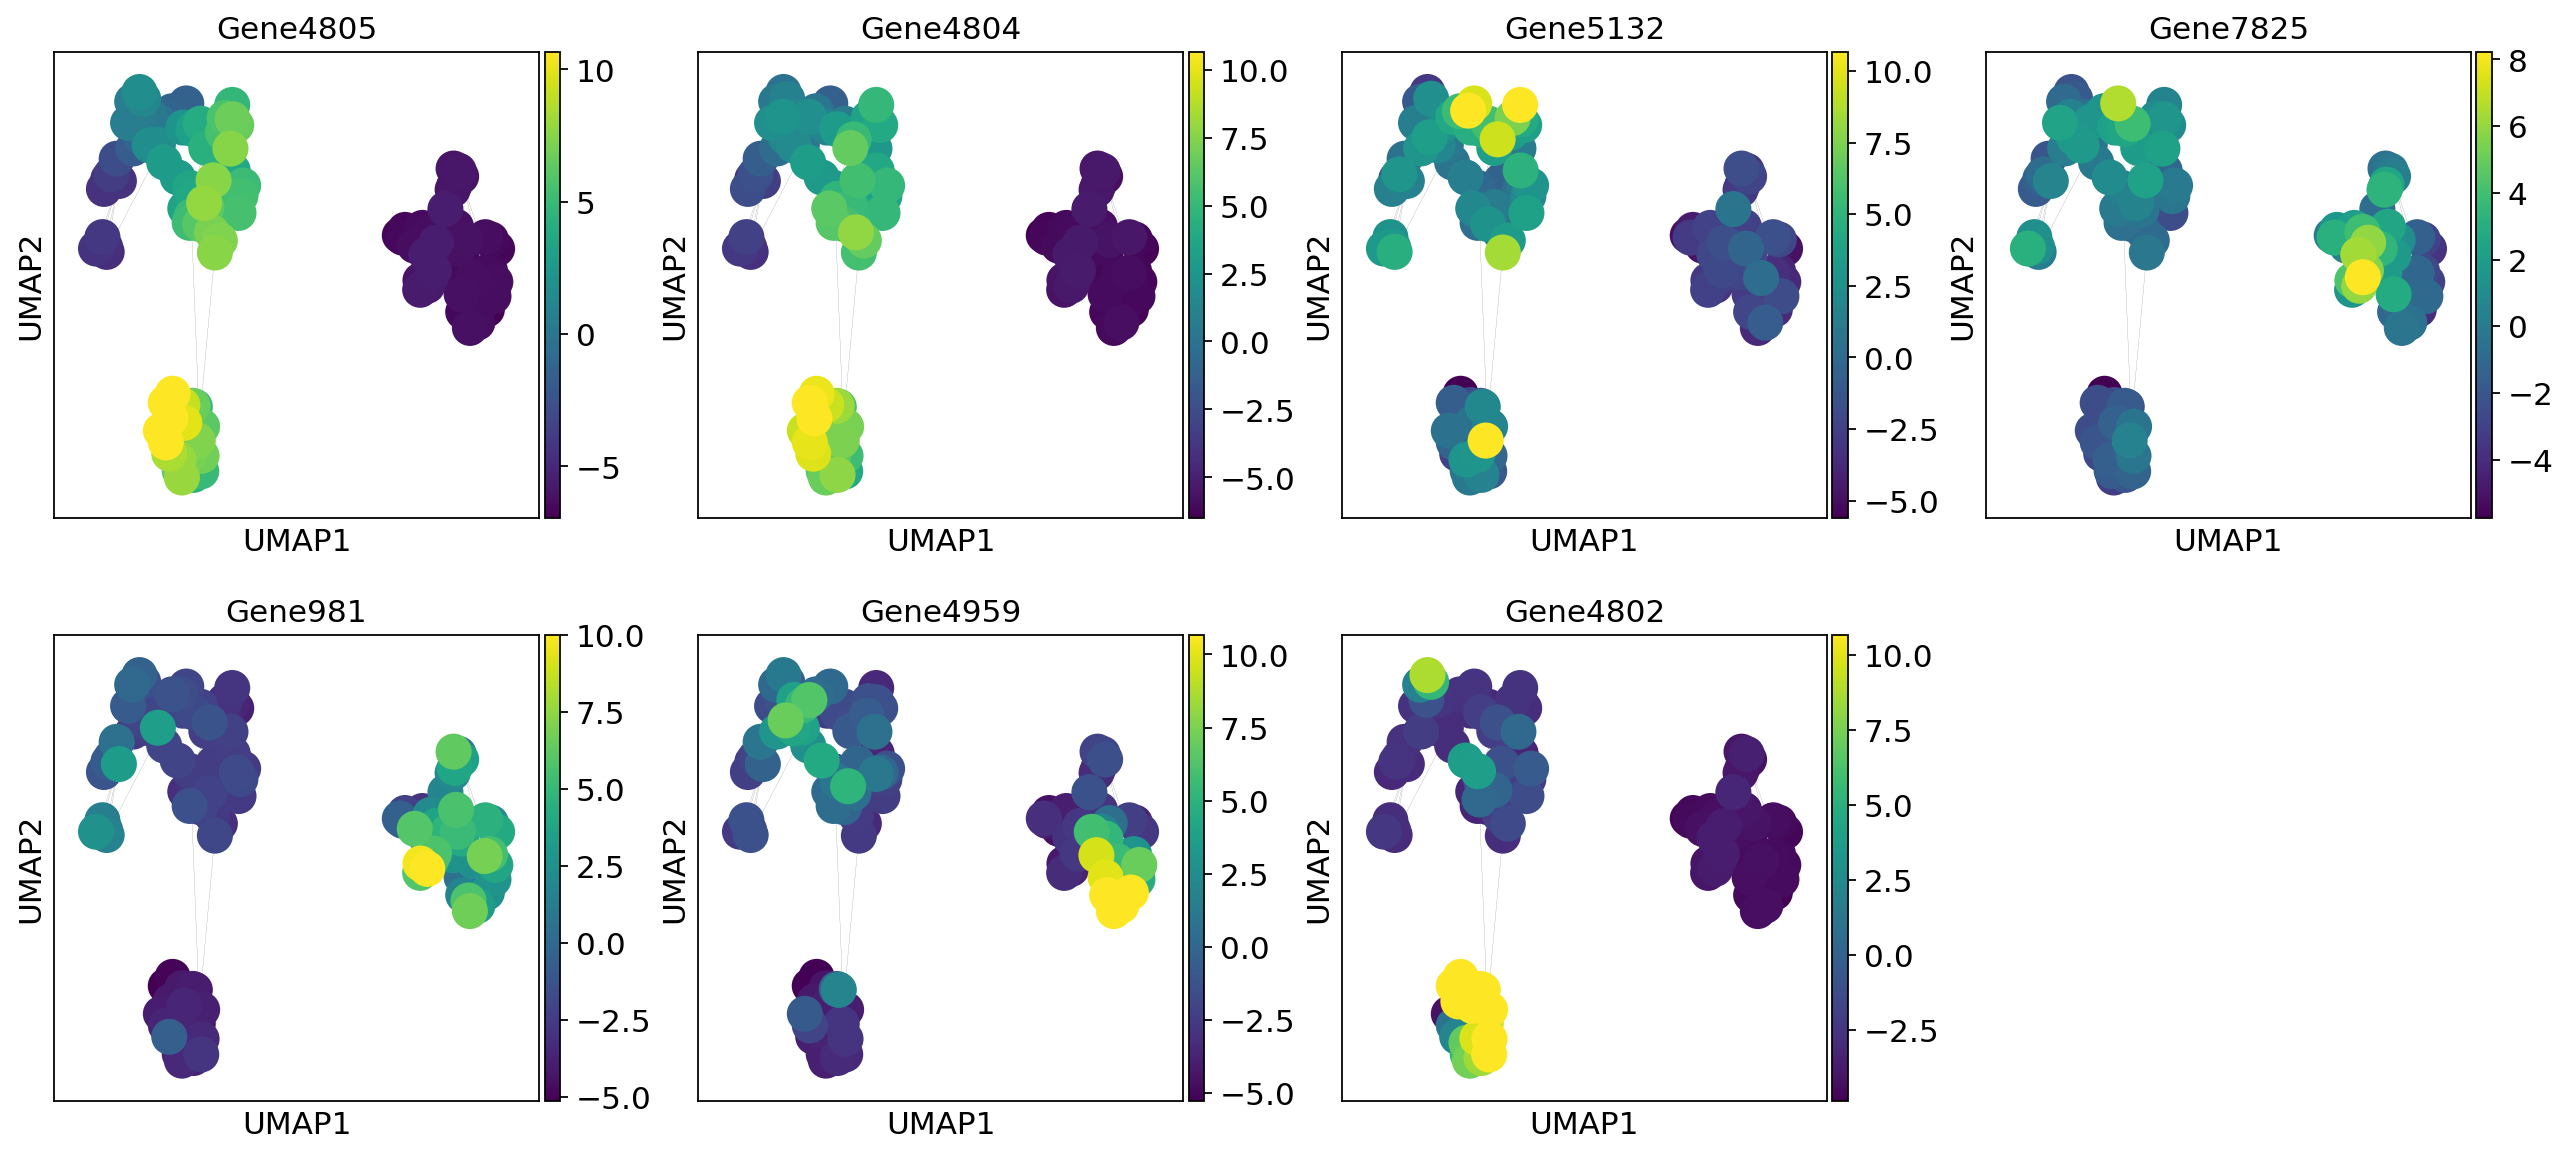

In [59]:
var_genes = adata.var.highly_variable
var_genes.index[var_genes]
varg = [x for x in top20 if x in var_genes.index[var_genes]]
sc.pl.umap(adata, color=varg, use_raw=False, edges=True)

**Time complexity:** The average complexity is $O(1)$ and the worst case is $O(n^{2})$

**Space complexity:** The space complexity is $O(V+E)$ and full connection of the graph requires $O(V^{2})$

# Part 2 - Question 2

**Strategy**: 
1. Create 5000x2 dataframe and randomly populate both rows with 0 or 1 in a 9:1 ratio. The two columns represent experimental and control. The control column has 10% gene expression (value 1), whereas the experimental column has 20% gene expression because the experimental condition is expected to induce a 10% increase in gene expression.
2. Extrapolate for 1000 genes. Assumption: all genes have 10% increase in expression within the experimental setting.
3. Z-test
4. Find the number of samples from each condition to achieve a power of 95%.

**Null hypothesis (H0):** There is no differential increase in gene expression in response to experimental conditions. <br>
**Alternative hypothesis (H1):** The gene is differentially expressed in experimental conditions. <br>
Null hypothesis is rejected if 10% increase in gene expression at Bonferroni-corrected p < 0.05.

In [60]:
n = 5000 # no of records
nog = 1000   # no of genes
gene_list = ["Gene" + str(i) for i in range(0,nog)]

#### Simulation 

In [61]:
def generate_gene_df(gene, n):

    df = pd.DataFrame.from_dict(
         {"Gene" : gene,
          "Cells": (f'Cell{x}' for x in range(1, n+1)),
          "Control": np.random.choice([1,0], p=[0.1, 0.9], size=n),
          "Experimental": np.random.choice([1,0], p=[0.1+0.1, 0.9-0.1], size=n)},
         orient='columns'
         )

    df = df.set_index(["Gene","Cells"])
    
    return df

#### Extrapolate for 1000 genes

In [62]:
# List of simulated genes
gene_df_list = [generate_gene_df(gene, n) for gene in gene_list]

df = pd.concat(gene_df_list)
df = df.reset_index()

#### Plot the statistical power

In [63]:
# Power function
def power(nobs, nsims, psig):
  pvals = []
  for i in range(nsims):
    gene1 = generate_gene_df('G', nobs)
    #ct = pd.crosstab(gene1.Control, gene1.Experimental)
    #chi, pval = chisquare(ct, axis=None)
    g_detected = gene1.sum(axis=0)
    zval, pval = proportions_ztest(g_detected, [nobs, nobs], alternative='two-sided')
    pvals.append(pval)
    
  nsig = sum(map(lambda x : x <= psig, pvals))  #num of pval less than 0.05
  return(nsig/nsims)

In [64]:
# Check the relationship between and power
psig = 0.05/1000
ns = np.arange(500, 1000, 10)
pows = []
for k in range(len(ns)):
  pw = power(ns[k], 1000, psig)
  pows.append(pw)

<function matplotlib.pyplot.show(close=None, block=None)>

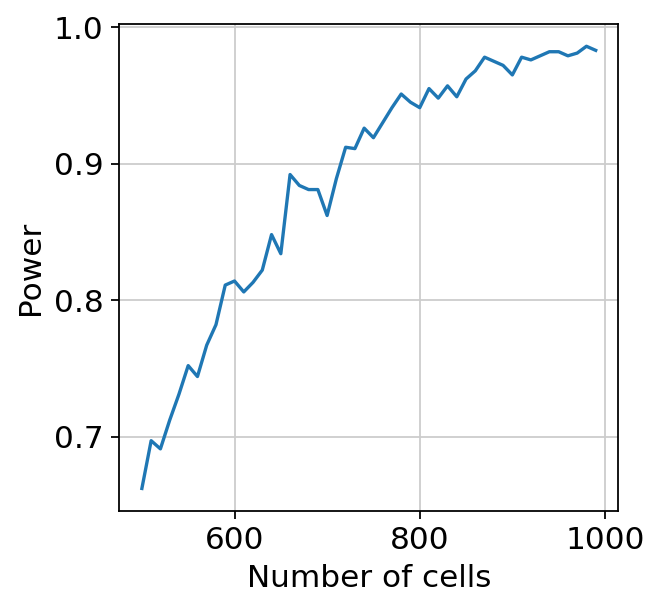

In [65]:
# Plot the statistical power
plt.figure(0)
plt.plot(ns,pows)
plt.xlabel("Number of cells")
plt.ylabel("Power")
plt.show

In [66]:
# Number of samples that meet criteria
count = sum(map(lambda p : p > 0.05, pows)) 
print('The minimum number of samples from each condition required to reject Null Hypothesis: %i' % count)

The minimum number of samples from each condition required to reject Null Hypothesis: 50


# References

- Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden: guaranteeing well-connected communities. Sci Rep 9, 5233 (2019). https://doi.org/10.1038/s41598-019-41695-z <br>
- Yu, L., Cao, Y., Yang, J.Y.H. et al. Benchmarking clustering algorithms on estimating the number of cell types from single-cell RNA-sequencing data. Genome Biol 23, 49 (2022). https://doi.org/10.1186/s13059-022-02622-0 <br>